In [106]:

import pandas as pd
import numpy as np
from scipy.stats.stats import pearsonr  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import datetime
import plotly.plotly as py
import matplotlib.pyplot as plt
import folium
# import json         # no se usa aun.
import branca.colormap as cm


## Carga de CSVs

## A continuacion se realiza la carga de archivos a los dataframe correspondientes.

In [2]:
dfEstaciones =pd.read_csv('../CSVs/station.csv', thousands=',', low_memory=False)
dfClima=pd.read_csv('../CSVs/weather.csv', thousands=',', low_memory=False)
dfViajes = pd.read_csv('../CSVs/trip.csv', thousands=',', low_memory=False)
#Df creado por nuestro grupo con la informacion que queriamos analizar de Status.csv
dfTableID_DocksAvailable = pd.read_csv('../CSVs/tabla_id_dockAvailable.csv')

   # Filtrado de dfEstaciones

## El objetivo es simplemente ver la estructura del dataframe y saber que informacion nos puede brindar.

In [3]:
print (dfEstaciones.shape) 

(70, 7)


In [4]:
dfEstaciones

id                                           name        lat        long  \
0    2              San Jose Diridon Caltrain Station  37.329732 -121.901782   
1    3                          San Jose Civic Center  37.330698 -121.888979   
2    4                         Santa Clara at Almaden  37.333988 -121.894902   
3    5                               Adobe on Almaden  37.331415 -121.893200   
4    6                               San Pedro Square  37.336721 -121.894074   
5    7                           Paseo de San Antonio  37.333798 -121.886943   
6    8                            San Salvador at 1st  37.330165 -121.885831   
7    9                                      Japantown  37.348742 -121.894715   
8   10                             San Jose City Hall  37.337391 -121.886995   
9   11                                    MLK Library  37.335885 -121.885660   
10  12                         SJSU 4th at San Carlos  37.332808 -121.883891   
11  13                                  St James Park  37.339301 -121.889937   
12  14                       Arena Green / SAP Center  37.332692 -121.900084   
13  16                     SJSU - San Salvador at 9th  37.333955 -121.877349   
14  21                              Franklin at Maple  37.481758 -122.226904   
15  22                  Redwood City Caltrain Station  37.486078 -122.232089   
16  23                        San Mateo County Center  37.487616 -122.229951   
17  24                    Redwood City Public Library  37.484219 -122.227424   
18  25                       Stanford in Redwood City  37.485370 -122.203288   
19  26                    Redwood City Medical Center  37.487682 -122.223492   
20  27                        Mountain View City Hall  37.389218 -122.081896   
21  28                 Mountain View Caltrain Station  37.394358 -122.076713   
22  29                   San Antonio Caltrain Station  37.406940 -122.106758   
23  30                           Evelyn Park and Ride  37.390277 -122.066553   
24  31                    San Antonio Shopping Center  37.400443 -122.108338   
25  32               Castro Street and El Camino Real  37.385956 -122.083678   
26  33          Rengstorff Avenue / California Street  37.400241 -122.099076   
27  34                     Palo Alto Caltrain Station  37.443988 -122.164759   
28  35                         University and Emerson  37.444521 -122.163093   
29  36                California Ave Caltrain Station  37.429082 -122.142805   
..  ..                                            ...        ...         ...   
40  51                          Embarcadero at Folsom  37.791464 -122.391034   
41  39                             Powell Street BART  37.783871 -122.408433   
42  54                          Embarcadero at Bryant  37.787152 -122.388013   
43  55  Temporary Transbay Terminal (Howard at Beale)  37.789756 -122.394643   
44  56                                Beale at Market  37.792251 -122.397086   
45  57                                  5th at Howard  37.781752 -122.405127   
46  58                        San Francisco City Hall  37.778650 -122.418235   
47  59                            Golden Gate at Polk  37.781332 -122.418603   
48  60                         Embarcadero at Sansome  37.804770 -122.403234   
49  61                                2nd at Townsend  37.780526 -122.390288   
50  62                                  2nd at Folsom  37.785299 -122.396236   
51  63                                  Howard at 2nd  37.786978 -122.398108   
52  64                              2nd at South Park  37.782259 -122.392738   
53  65                                Townsend at 7th  37.771058 -122.402717   
54  66                       South Van Ness at Market  37.774814 -122.418954   
55  67                                 Market at 10th  37.776619 -122.417385   
56  68  Yerba Buena Center of the Arts (3rd @ Howard)  37.784878 -122.401014   
57  69        San Francisco Caltrain 2 (330 Townsend)  37.776600 -122.395470   
58  

In [5]:
dfEstaciones.dtypes

id                     int64
name                  object
lat                  float64
long                 float64
dock_count             int64
city                  object
installation_date     object
dtype: object

In [6]:
# No tenemos nullos
dfEstaciones.isnull().sum()

id                   0
name                 0
lat                  0
long                 0
dock_count           0
city                 0
installation_date    0
dtype: int64

In [7]:
#Pasamos el campo installation_date al tipo datetime
dfEstaciones.installation_date = pd.to_datetime(dfEstaciones.installation_date, format = "%m/%d/%Y").dt.date

#Probamos si funciona correctamente
print (dfEstaciones.installation_date.min())
print (dfEstaciones.installation_date.max())

2013-08-05
2014-04-09


# Filtrado de df Status.csv

## status.csv era un archivo de 2GB el cual fue reducido a una tabla con la informacion que ibamos a utilizar, esta contiene la estaciones agrupadas por ID junto con los docks_available en promedio. 
## El objetivo es obtener un porcentaje, el cual represanta la utilidad de esa estacion, es decir que tanto se utilizan sus docks en relacion a los disponibles.

In [408]:
dfTableID_DocksAvailable.head()

station_id  docks_available
0           2        13.761535
1           3         6.527884
2           4         5.685249
3           5        10.868663
4           6         7.383773

In [409]:
dfEstaciones.head()

id                               name        lat        long  dock_count  \
0   2  San Jose Diridon Caltrain Station  37.329732 -121.901782          27   
1   3              San Jose Civic Center  37.330698 -121.888979          15   
2   4             Santa Clara at Almaden  37.333988 -121.894902          11   
3   5                   Adobe on Almaden  37.331415 -121.893200          19   
4   6                   San Pedro Square  37.336721 -121.894074          15   

       city installation_date  
0  San Jose        2013-08-06  
1  San Jose        2013-08-05  
2  San Jose        2013-08-06  
3  San Jose        2013-08-05  
4  San Jose        2013-08-07

In [410]:
#Realizamos merge de dataframe 'dfEstaciones' con 'dfTableID_DocksAvailable' por ID de estacion
dfusagePercentagePerStation = dfEstaciones.merge(dfTableID_DocksAvailable, left_on='id', right_on='station_id').drop('station_id', 1)
dfusagePercentagePerStation

id                                           name        lat        long  \
0    2              San Jose Diridon Caltrain Station  37.329732 -121.901782   
1    3                          San Jose Civic Center  37.330698 -121.888979   
2    4                         Santa Clara at Almaden  37.333988 -121.894902   
3    5                               Adobe on Almaden  37.331415 -121.893200   
4    6                               San Pedro Square  37.336721 -121.894074   
5    7                           Paseo de San Antonio  37.333798 -121.886943   
6    8                            San Salvador at 1st  37.330165 -121.885831   
7    9                                      Japantown  37.348742 -121.894715   
8   10                             San Jose City Hall  37.337391 -121.886995   
9   11                                    MLK Library  37.335885 -121.885660   
10  12                         SJSU 4th at San Carlos  37.332808 -121.883891   
11  13                                  St James Park  37.339301 -121.889937   
12  14                       Arena Green / SAP Center  37.332692 -121.900084   
13  16                     SJSU - San Salvador at 9th  37.333955 -121.877349   
14  21                              Franklin at Maple  37.481758 -122.226904   
15  22                  Redwood City Caltrain Station  37.486078 -122.232089   
16  23                        San Mateo County Center  37.487616 -122.229951   
17  24                    Redwood City Public Library  37.484219 -122.227424   
18  25                       Stanford in Redwood City  37.485370 -122.203288   
19  26                    Redwood City Medical Center  37.487682 -122.223492   
20  27                        Mountain View City Hall  37.389218 -122.081896   
21  28                 Mountain View Caltrain Station  37.394358 -122.076713   
22  29                   San Antonio Caltrain Station  37.406940 -122.106758   
23  30                           Evelyn Park and Ride  37.390277 -122.066553   
24  31                    San Antonio Shopping Center  37.400443 -122.108338   
25  32               Castro Street and El Camino Real  37.385956 -122.083678   
26  33          Rengstorff Avenue / California Street  37.400241 -122.099076   
27  34                     Palo Alto Caltrain Station  37.443988 -122.164759   
28  35                         University and Emerson  37.444521 -122.163093   
29  36                California Ave Caltrain Station  37.429082 -122.142805   
..  ..                                            ...        ...         ...   
40  51                          Embarcadero at Folsom  37.791464 -122.391034   
41  39                             Powell Street BART  37.783871 -122.408433   
42  54                          Embarcadero at Bryant  37.787152 -122.388013   
43  55  Temporary Transbay Terminal (Howard at Beale)  37.789756 -122.394643   
44  56                                Beale at Market  37.792251 -122.397086   
45  57                                  5th at Howard  37.781752 -122.405127   
46  58                        San Francisco City Hall  37.778650 -122.418235   
47  59                            Golden Gate at Polk  37.781332 -122.418603   
48  60                         Embarcadero at Sansome  37.804770 -122.403234   
49  61                                2nd at Townsend  37.780526 -122.390288   
50  62                                  2nd at Folsom  37.785299 -122.396236   
51  63                                  Howard at 2nd  37.786978 -122.398108   
52  64                              2nd at South Park  37.782259 -122.392738   
53  65                                Townsend at 7th  37.771058 -122.402717   
54  66                       South Van Ness at Market  37.774814 -122.418954   
55  67                                 Market at 10th  37.776619 -122.417385   
56  68  Yerba Buena Center of the Arts (3rd @ Howard)  37.784878 -122.401014   
57  69        San Francisco Caltrain 2 (330 Townsend)  37.776600 -122.395470   
58  

In [411]:
#Le damos un nombre mas significado al feature
dfusagePercentagePerStation = dfusagePercentagePerStation.rename(columns={'docks_available': 'mean_of_docks_available'})
dfusagePercentagePerStation

id                                           name        lat        long  \
0    2              San Jose Diridon Caltrain Station  37.329732 -121.901782   
1    3                          San Jose Civic Center  37.330698 -121.888979   
2    4                         Santa Clara at Almaden  37.333988 -121.894902   
3    5                               Adobe on Almaden  37.331415 -121.893200   
4    6                               San Pedro Square  37.336721 -121.894074   
5    7                           Paseo de San Antonio  37.333798 -121.886943   
6    8                            San Salvador at 1st  37.330165 -121.885831   
7    9                                      Japantown  37.348742 -121.894715   
8   10                             San Jose City Hall  37.337391 -121.886995   
9   11                                    MLK Library  37.335885 -121.885660   
10  12                         SJSU 4th at San Carlos  37.332808 -121.883891   
11  13                                  St James Park  37.339301 -121.889937   
12  14                       Arena Green / SAP Center  37.332692 -121.900084   
13  16                     SJSU - San Salvador at 9th  37.333955 -121.877349   
14  21                              Franklin at Maple  37.481758 -122.226904   
15  22                  Redwood City Caltrain Station  37.486078 -122.232089   
16  23                        San Mateo County Center  37.487616 -122.229951   
17  24                    Redwood City Public Library  37.484219 -122.227424   
18  25                       Stanford in Redwood City  37.485370 -122.203288   
19  26                    Redwood City Medical Center  37.487682 -122.223492   
20  27                        Mountain View City Hall  37.389218 -122.081896   
21  28                 Mountain View Caltrain Station  37.394358 -122.076713   
22  29                   San Antonio Caltrain Station  37.406940 -122.106758   
23  30                           Evelyn Park and Ride  37.390277 -122.066553   
24  31                    San Antonio Shopping Center  37.400443 -122.108338   
25  32               Castro Street and El Camino Real  37.385956 -122.083678   
26  33          Rengstorff Avenue / California Street  37.400241 -122.099076   
27  34                     Palo Alto Caltrain Station  37.443988 -122.164759   
28  35                         University and Emerson  37.444521 -122.163093   
29  36                California Ave Caltrain Station  37.429082 -122.142805   
..  ..                                            ...        ...         ...   
40  51                          Embarcadero at Folsom  37.791464 -122.391034   
41  39                             Powell Street BART  37.783871 -122.408433   
42  54                          Embarcadero at Bryant  37.787152 -122.388013   
43  55  Temporary Transbay Terminal (Howard at Beale)  37.789756 -122.394643   
44  56                                Beale at Market  37.792251 -122.397086   
45  57                                  5th at Howard  37.781752 -122.405127   
46  58                        San Francisco City Hall  37.778650 -122.418235   
47  59                            Golden Gate at Polk  37.781332 -122.418603   
48  60                         Embarcadero at Sansome  37.804770 -122.403234   
49  61                                2nd at Townsend  37.780526 -122.390288   
50  62                                  2nd at Folsom  37.785299 -122.396236   
51  63                                  Howard at 2nd  37.786978 -122.398108   
52  64                              2nd at South Park  37.782259 -122.392738   
53  65                                Townsend at 7th  37.771058 -122.402717   
54  66                       South Van Ness at Market  37.774814 -122.418954   
55  67                                 Market at 10th  37.776619 -122.417385   
56  68  Yerba Buena Center of the Arts (3rd @ Howard)  37.784878 -122.401014   
57  69        San Francisco Caltrain 2 (330 Townsend)  37.776600 -122.395470   
58  

In [412]:
#Obtenemos el porcentaje de utilidad de cada estacion
dfusagePercentagePerStation['docks_usage_percentage'] = dfusagePercentagePerStation.mean_of_docks_available/dfusagePercentagePerStation.dock_count
dfusagePercentagePerStation

id                                           name        lat        long  \
0    2              San Jose Diridon Caltrain Station  37.329732 -121.901782   
1    3                          San Jose Civic Center  37.330698 -121.888979   
2    4                         Santa Clara at Almaden  37.333988 -121.894902   
3    5                               Adobe on Almaden  37.331415 -121.893200   
4    6                               San Pedro Square  37.336721 -121.894074   
5    7                           Paseo de San Antonio  37.333798 -121.886943   
6    8                            San Salvador at 1st  37.330165 -121.885831   
7    9                                      Japantown  37.348742 -121.894715   
8   10                             San Jose City Hall  37.337391 -121.886995   
9   11                                    MLK Library  37.335885 -121.885660   
10  12                         SJSU 4th at San Carlos  37.332808 -121.883891   
11  13                                  St James Park  37.339301 -121.889937   
12  14                       Arena Green / SAP Center  37.332692 -121.900084   
13  16                     SJSU - San Salvador at 9th  37.333955 -121.877349   
14  21                              Franklin at Maple  37.481758 -122.226904   
15  22                  Redwood City Caltrain Station  37.486078 -122.232089   
16  23                        San Mateo County Center  37.487616 -122.229951   
17  24                    Redwood City Public Library  37.484219 -122.227424   
18  25                       Stanford in Redwood City  37.485370 -122.203288   
19  26                    Redwood City Medical Center  37.487682 -122.223492   
20  27                        Mountain View City Hall  37.389218 -122.081896   
21  28                 Mountain View Caltrain Station  37.394358 -122.076713   
22  29                   San Antonio Caltrain Station  37.406940 -122.106758   
23  30                           Evelyn Park and Ride  37.390277 -122.066553   
24  31                    San Antonio Shopping Center  37.400443 -122.108338   
25  32               Castro Street and El Camino Real  37.385956 -122.083678   
26  33          Rengstorff Avenue / California Street  37.400241 -122.099076   
27  34                     Palo Alto Caltrain Station  37.443988 -122.164759   
28  35                         University and Emerson  37.444521 -122.163093   
29  36                California Ave Caltrain Station  37.429082 -122.142805   
..  ..                                            ...        ...         ...   
40  51                          Embarcadero at Folsom  37.791464 -122.391034   
41  39                             Powell Street BART  37.783871 -122.408433   
42  54                          Embarcadero at Bryant  37.787152 -122.388013   
43  55  Temporary Transbay Terminal (Howard at Beale)  37.789756 -122.394643   
44  56                                Beale at Market  37.792251 -122.397086   
45  57                                  5th at Howard  37.781752 -122.405127   
46  58                        San Francisco City Hall  37.778650 -122.418235   
47  59                            Golden Gate at Polk  37.781332 -122.418603   
48  60                         Embarcadero at Sansome  37.804770 -122.403234   
49  61                                2nd at Townsend  37.780526 -122.390288   
50  62                                  2nd at Folsom  37.785299 -122.396236   
51  63                                  Howard at 2nd  37.786978 -122.398108   
52  64                              2nd at South Park  37.782259 -122.392738   
53  65                                Townsend at 7th  37.771058 -122.402717   
54  66                       South Van Ness at Market  37.774814 -122.418954   
55  67                                 Market at 10th  37.776619 -122.417385   
56  68  Yerba Buena Center of the Arts (3rd @ Howard)  37.784878 -122.401014   
57  69        San Francisco Caltrain 2 (330 Townsend)  37.776600 -122.395470   
58  

In [413]:
dfusagePercentagePerStation.to_csv('../CSVs/usagePercentagePerStation.csv')

# Filtrado de dfClima
## El objetivo es simplemente ver la estructura del dataframe y saber que informacion nos puede brindar.

In [14]:
dfClima

date  max_temperature_f  mean_temperature_f  min_temperature_f  \
0     8/29/2013                 74                  68                 61   
1     8/30/2013                 78                  69                 60   
2     8/31/2013                 71                  64                 57   
3      9/1/2013                 74                  66                 58   
4      9/2/2013                 75                  69                 62   
5      9/3/2013                 73                  67                 60   
6      9/4/2013                 74                  68                 61   
7      9/5/2013                 72                  66                 60   
8      9/6/2013                 85                  71                 56   
9      9/7/2013                 88                  73                 58   
10     9/8/2013                 74                  65                 56   
11     9/9/2013                 76                  66                 55   
12    9/10/2013                 74                  66                 57   
13    9/11/2013                 74                  68                 62   
14    9/12/2013                 71                  65                 59   
15    9/13/2013                 66                  62                 57   
16    9/14/2013                 66                  62                 57   
17    9/15/2013                 73                  66                 58   
18    9/16/2013                 71                  65                 59   
19    9/17/2013                 68                  63                 57   
20    9/18/2013                 78                  66                 54   
21    9/19/2013                 80                  67                 54   
22    9/20/2013                 73                  65                 56   
23    9/21/2013                 68                  63                 58   
24    9/22/2013                 70                  63                 55   
25    9/23/2013                 78                  68                 57   
26    9/24/2013                 71                  65                 58   
27    9/25/2013                 67                  62                 56   
28    9/26/2013                 71                  62                 53   
29    9/27/2013                 78                  66                 54   
...         ...                ...                 ...                ...   
3635   8/2/2015                 76                  70                 63   
3636   8/3/2015                 77                  69                 61   
3637   8/4/2015                 76                  67                 58   
3638   8/5/2015                 79                  69                 58   
3639   8/6/2015                 78                  70                 61   
3640   8/7/2015                 83                  72                 60   
3641   8/8/2015                 78                  69                 60   
3642   8/9/2015                 78                  68                 57   
3643  8/10/2015                 80                  70                 60   
3644  8/11/2015                 82                  71                 60   
3645  8/12/2015                 81                  69                 57   
3646  8/13/2015                 80                  72                 64   
3647  8/14/2015                 79                  72                 64   
3648  8/15/2015                 93                  76                 59   
3649  8/16/2015                 97                  82                 66   
3650  8/17/2015                 91                  77                 63   
3651  8/18/2015                 81                  70                 58   
3652  8/19/2015                 77                  69                 61   
3653  8/20/2015                 75                  69                 62   
3654  8/21/2015                 79                  70                 60   
3655  8

In [15]:
dfClima.shape

(3665, 24)

In [16]:
#Vemos que contiene muchos nulos
dfClima.isnull().sum()

date                                 0
max_temperature_f                    4
mean_temperature_f                   4
min_temperature_f                    4
max_dew_point_f                     54
mean_dew_point_f                    54
min_dew_point_f                     54
max_humidity                        54
mean_humidity                       54
min_humidity                        54
max_sea_level_pressure_inches        1
mean_sea_level_pressure_inches       1
min_sea_level_pressure_inches        1
max_visibility_miles                13
mean_visibility_miles               13
min_visibility_miles                13
max_wind_Speed_mph                   1
mean_wind_speed_mph                  1
max_gust_speed_mph                 899
precipitation_inches                 1
cloud_cover                          1
events                            3143
wind_dir_degrees                     1
zip_code                             0
dtype: int64

In [17]:
#Pasamos a datetime
dfClima.date = pd.to_datetime(dfClima.date, format='%m/%d/%Y')

In [18]:
dfClima.head(10)

date  max_temperature_f  mean_temperature_f  min_temperature_f  \
0 2013-08-29                 74                  68                 61   
1 2013-08-30                 78                  69                 60   
2 2013-08-31                 71                  64                 57   
3 2013-09-01                 74                  66                 58   
4 2013-09-02                 75                  69                 62   
5 2013-09-03                 73                  67                 60   
6 2013-09-04                 74                  68                 61   
7 2013-09-05                 72                  66                 60   
8 2013-09-06                 85                  71                 56   
9 2013-09-07                 88                  73                 58   

   max_dew_point_f  mean_dew_point_f  min_dew_point_f  max_humidity  \
0               61                58               56            93   
1               61                58               56            90   
2               57                56               54            93   
3               60                56               53            87   
4               61                60               58            93   
5               59                56               51            84   
6               59                57               56            90   
7               57                56               54            90   
8               57                51               45            86   
9               64                54               46            86   

   mean_humidity  min_humidity   ...     mean_visibility_miles  \
0             75            57   ...                        10   
1             70            50   ...                        10   
2             75            57   ...                        10   
3             68            49   ...                        10   
4             77            61   ...                        10   
5             65            46   ...                        10   
6             72            53   ...                        10   
7             74            57   ...                        10   
8             58            29   ...                        10   
9             59            31   ...                        10   

   min_visibility_miles  max_wind_Speed_mph  mean_wind_speed_mph  \
0                    10                  23                   11   
1                     7                  29                   13   
2                    10                  26                   15   
3                    10                  25                   13   
4                     6                  23                   12   
5                    10                  24                   15   
6                    10                  29                   19   
7                    10                  31                   21   
8                    10                  24                    8   
9                    10                  21                    8   

   max_gust_speed_mph  precipitation_inches  cloud_cover  events  \
0                  28                     0            4     NaN   
1                  35                     0            2     NaN   
2                  31                     0            4     NaN   
3                  29                     0            4     NaN   
4                  30                     0            6     NaN   
5                  31                     0            2     NaN   
6                  35                     0            4     NaN   
7                  37                     0            3     NaN   
8                  28                     0            0     NaN   
9                  25                     0            1     NaN   

   wind_dir_degrees zip_code  
0               286    94107  
1               291    94107  
2               284    94107  
3               284    94107  
4               277    94107  


In [19]:
dfClima.events.unique()

array([nan, 'Fog', 'Rain', 'Fog-Rain', 'rain', 'Rain-Thunderstorm'], dtype=object)

In [20]:
#Limpio los datos bugeados, tenemos mucha informacion nula, la cual decidimos pasar a Normal
#Tambien corregi
dfClima.loc[dfClima.events == 'rain', 'events'] = "Rain"
dfClima.loc[dfClima.events.isnull(), 'events'] = "Normal"

In [21]:
# EL zip_code es el codigo postal para las 5 ciudades de la bahia
dfClima.zip_code.unique()

array([94107, 94063, 94301, 94041, 95113])

In [22]:
# Vemos cual de estos zip code tiene menos nulos
for zc in dfClima.zip_code.unique():
    print (dfClima[dfClima.zip_code == zc].isnull().sum())
    print ()

date                               0
max_temperature_f                  0
mean_temperature_f                 0
min_temperature_f                  0
max_dew_point_f                    0
mean_dew_point_f                   0
min_dew_point_f                    0
max_humidity                       0
mean_humidity                      0
min_humidity                       0
max_sea_level_pressure_inches      0
mean_sea_level_pressure_inches     0
min_sea_level_pressure_inches      0
max_visibility_miles               0
mean_visibility_miles              0
min_visibility_miles               0
max_wind_Speed_mph                 0
mean_wind_speed_mph                0
max_gust_speed_mph                13
precipitation_inches               0
cloud_cover                        0
events                             0
wind_dir_degrees                   0
zip_code                           0
dtype: int64
()
date                                0
max_temperature_f                   0
mean_temperature_f  

In [23]:
#Trabajamos con el zip_code == 94107, es el mas 'limpio' de nulos, dada la cercania de todas las ciudades 
#la informacion no puede ser muy cambiante entre estas, por lo cual consideramos valido filtrar por una en particular.
dfClimaLimpio = dfClima[dfClima.zip_code == 94107]
dfClimaLimpio.shape

(733, 24)

In [24]:
dfClimaLimpio.events

0                  Normal
1                  Normal
2                  Normal
3                  Normal
4                  Normal
5                  Normal
6                  Normal
7                  Normal
8                  Normal
9                  Normal
10                 Normal
11                 Normal
12                 Normal
13                 Normal
14                    Fog
15                 Normal
16                 Normal
17                 Normal
18                 Normal
19                 Normal
20                 Normal
21                 Normal
22                 Normal
23                   Rain
24                 Normal
25                 Normal
26                 Normal
27                 Normal
28                 Normal
29                 Normal
              ...        
2175               Normal
2176               Normal
2177               Normal
2178               Normal
2179    Rain-Thunderstorm
2180               Normal
2181               Normal
2182        

In [25]:
#Transformamos el feature events, en un nuevo dataframe el cual añadiremos a dfClimaLimpio
events = pd.get_dummies(dfClimaLimpio.events)
events

Fog  Fog-Rain  Normal  Rain  Rain-Thunderstorm
0       0         0       1     0                  0
1       0         0       1     0                  0
2       0         0       1     0                  0
3       0         0       1     0                  0
4       0         0       1     0                  0
5       0         0       1     0                  0
6       0         0       1     0                  0
7       0         0       1     0                  0
8       0         0       1     0                  0
9       0         0       1     0                  0
10      0         0       1     0                  0
11      0         0       1     0                  0
12      0         0       1     0                  0
13      0         0       1     0                  0
14      1         0       0     0                  0
15      0         0       1     0                  0
16      0         0       1     0                  0
17      0         0       1     0                  0
18      0         0       1     0                  0
19      0         0       1     0                  0
20      0         0       1     0                  0
21      0         0       1     0                  0
22      0         0       1     0                  0
23      0         0       0     1                  0
24      0         0       1     0                  0
25      0         0       1     0                  0
26      0         0       1     0                  0
27      0         0       1     0                  0
28      0         0       1     0                  0
29      0         0       1     0                  0
...   ...       ...     ...   ...                ...
2175    0         0       1     0                  0
2176    0         0       1     0                  0
2177    0         0       1     0                  0
2178    0         0       1     0                  0
2179    0         0       0     0                  1
2180    0         0       1     0                  0
2181    0         0       1     0                  0
2182    0         0       1     0                  0
2183    0         0       1     0                  0
2184    0         0       1     0                  0
2185    0         0       1     0                  0
2186    0         0       1     0                  0
2187    0         0       1     0                  0
2188    0         0       1     0                  0
2189    0         0       1     0                  0
2190    0         0       1     0                  0
2191    0         0       1     0                  0
2192    0         0       1     0                  0
2193    0         0       1     0                  0
2194    0         0       1     0                  0
2195    0         0       1     0                  0
2196    0         0       1     0                  0
2197    0         0       1     0                  0
2198    0         0       1     0                  0
2199    0         0       1     0                  0
2200    0         0       1     0                  0
2201    0         0       1     0                  0
2202    0         0       0     1                  0
2203    0         0       1     0                  0
2204    0         0       1     0                  0

[733 rows x 5 columns]

In [26]:
#Mergeo los 2 data frames, eventos con dfClimaLimpio
dfClimaLimpio = dfClimaLimpio.merge(events, left_index = True, right_index = True)
#Saco los features que no voy a usar
dfClimaLimpio = dfClimaLimpio.drop(['events','zip_code'],1)

In [27]:
#Todavia tenemos nulos
dfClimaLimpio.isnull().sum()

date                               0
max_temperature_f                  0
mean_temperature_f                 0
min_temperature_f                  0
max_dew_point_f                    0
mean_dew_point_f                   0
min_dew_point_f                    0
max_humidity                       0
mean_humidity                      0
min_humidity                       0
max_sea_level_pressure_inches      0
mean_sea_level_pressure_inches     0
min_sea_level_pressure_inches      0
max_visibility_miles               0
mean_visibility_miles              0
min_visibility_miles               0
max_wind_Speed_mph                 0
mean_wind_speed_mph                0
max_gust_speed_mph                13
precipitation_inches               0
cloud_cover                        0
wind_dir_degrees                   0
Fog                                0
Fog-Rain                           0
Normal                             0
Rain                               0
Rain-Thunderstorm                  0
d

In [28]:
#El campo max_gust_speed_mph no esta limpio todavia, lo trabajo
#Para cada valor de max_wind, busco la media de max_gust y la uso para rellenar los nulos.
dfClimaLimpio.loc[dfClimaLimpio.max_gust_speed_mph.isnull(), 'max_gust_speed_mph'] = \
                                dfClimaLimpio.groupby('max_wind_Speed_mph').\
                                max_gust_speed_mph.apply(lambda x: x.fillna(x.median()))

In [29]:
# Listo para usar
dfClimaLimpio.isnull().sum()

date                              0
max_temperature_f                 0
mean_temperature_f                0
min_temperature_f                 0
max_dew_point_f                   0
mean_dew_point_f                  0
min_dew_point_f                   0
max_humidity                      0
mean_humidity                     0
min_humidity                      0
max_sea_level_pressure_inches     0
mean_sea_level_pressure_inches    0
min_sea_level_pressure_inches     0
max_visibility_miles              0
mean_visibility_miles             0
min_visibility_miles              0
max_wind_Speed_mph                0
mean_wind_speed_mph               0
max_gust_speed_mph                0
precipitation_inches              0
cloud_cover                       0
wind_dir_degrees                  0
Fog                               0
Fog-Rain                          0
Normal                            0
Rain                              0
Rain-Thunderstorm                 0
dtype: int64

In [30]:
# el campo precipitation_inches lo deseamos de tipo numerico
dfClimaLimpio.dtypes

date                              datetime64[ns]
max_temperature_f                        float64
mean_temperature_f                       float64
min_temperature_f                        float64
max_dew_point_f                          float64
mean_dew_point_f                         float64
min_dew_point_f                          float64
max_humidity                             float64
mean_humidity                            float64
min_humidity                             float64
max_sea_level_pressure_inches            float64
mean_sea_level_pressure_inches           float64
min_sea_level_pressure_inches            float64
max_visibility_miles                     float64
mean_visibility_miles                    float64
min_visibility_miles                     float64
max_wind_Speed_mph                       float64
mean_wind_speed_mph                      float64
max_gust_speed_mph                       float64
precipitation_inches                      object
cloud_cover         

In [31]:
dfClimaLimpio.precipitation_inches


0          0
1          0
2          0
3          0
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11         0
12         0
13         0
14         0
15         0
16         0
17         0
18         0
19         0
20         0
21         0
22         0
23      0.23
24         0
25         0
26         0
27         0
28         0
29         0
        ... 
2175       0
2176       0
2177       0
2178       0
2179       T
2180       0
2181       0
2182       0
2183       0
2184       0
2185       0
2186       0
2187       0
2188       0
2189       0
2190       0
2191       0
2192       0
2193       0
2194       0
2195       0
2196       0
2197       0
2198       0
2199       0
2200       0
2201       0
2202       T
2203       0
2204       0
Name: precipitation_inches, dtype: object

In [32]:
#Cambio el feature de string a numeric, los valores que son 'T' los cambio por NAN
dfClimaLimpio.precipitation_inches = pd.to_numeric(dfClimaLimpio.precipitation_inches, errors = 'coerce')

In [33]:
#Change null values to the median, of values > 0, because T, I think, means True. 
#Therefore we want to find the median amount of precipitation on days when it rained.
dfClimaLimpio.loc[dfClimaLimpio.precipitation_inches.isnull(), 'precipitation_inches'] = \
dfClimaLimpio[dfClimaLimpio.precipitation_inches.notnull()].precipitation_inches.median()

## Cambiamos unidades norteamericanas por unidades mks

In [34]:
# Cambiamos nombre de features
dfClimaLimpio=dfClimaLimpio.rename(columns={'max_temperature_f':'max_temperature_c', 'mean_temperature_f':'mean_temperature_c',\
            'max_dew_point_f':'max_dew_point_c','min_temperature_f':'min_temperature_c',\
            'mean_dew_point_f':'mean_dew_point_c','min_dew_point_f':'min_dew_point_c',\
            'max_sea_level_pressure_inches':'max_sea_level_pressure_cm','mean_sea_level_pressure_inches':'mean_sea_level_pressure_cm', \
            'min_sea_level_pressure_inches':'min_sea_level_pressure_cm','precipitation_inches':'precipitation_cm', \
            'max_visibility_miles':'max_visibility_km','mean_visibility_miles':'mean_visibility_km', \
            'min_visibility_miles':'min_visibility_km','max_wind_Speed_mph':'max_wind_Speed_kmh',\
            'mean_wind_speed_mph':'mean_wind_speed_kmh','max_gust_speed_mph':'max_gust_speed_kmh'})

In [35]:
#Aplicamos las funciones para el cambio de unidades
def farToCelsius(x):
    x = (x - 32 )/ 1.8
    return float(x)

def pulgToCm(x):
    x = x * 2.54
    return float(x)
def milesToKm (x):
    x = x* 1.60934
    return float(x)

dfClimaLimpio.max_temperature_c = dfClimaLimpio.max_temperature_c.apply(farToCelsius)
dfClimaLimpio.mean_temperature_c = dfClimaLimpio.mean_temperature_c.apply(farToCelsius)
dfClimaLimpio.min_temperature_c =dfClimaLimpio.min_temperature_c.apply(farToCelsius)
dfClimaLimpio.max_dew_point_c = dfClimaLimpio.max_dew_point_c.apply(farToCelsius)
dfClimaLimpio.mean_dew_point_c = dfClimaLimpio.mean_dew_point_c.apply(farToCelsius)
dfClimaLimpio.min_dew_point_c = dfClimaLimpio.min_dew_point_c.apply(farToCelsius)
dfClimaLimpio.max_sea_level_pressure_cm = dfClimaLimpio.max_sea_level_pressure_cm.apply(pulgToCm)
dfClimaLimpio.mean_sea_level_pressure_cm= dfClimaLimpio.mean_sea_level_pressure_cm.apply(pulgToCm)
dfClimaLimpio.min_sea_level_pressure_cm = dfClimaLimpio.min_sea_level_pressure_cm.apply(pulgToCm)
dfClimaLimpio.precipitation_cm = dfClimaLimpio.precipitation_cm.apply(pulgToCm)
dfClimaLimpio.max_visibility_km = dfClimaLimpio.max_visibility_km.apply(milesToKm)
dfClimaLimpio.mean_visibility_km = dfClimaLimpio.mean_visibility_km.apply(milesToKm)
dfClimaLimpio.min_visibility_km = dfClimaLimpio.min_visibility_km.apply(milesToKm)
dfClimaLimpio.max_wind_Speed_kmh = dfClimaLimpio.max_wind_Speed_kmh.apply(milesToKm)
dfClimaLimpio.mean_wind_speed_kmh = dfClimaLimpio.mean_wind_speed_kmh.apply(milesToKm)
dfClimaLimpio.max_gust_speed_kmhh = dfClimaLimpio.max_gust_speed_kmh.apply(milesToKm)



dfClimaLimpio

date  max_temperature_c  mean_temperature_c  min_temperature_c  \
0    2013-08-29          23.333333           20.000000          16.111111   
1    2013-08-30          25.555556           20.555556          15.555556   
2    2013-08-31          21.666667           17.777778          13.888889   
3    2013-09-01          23.333333           18.888889          14.444444   
4    2013-09-02          23.888889           20.555556          16.666667   
5    2013-09-03          22.777778           19.444444          15.555556   
6    2013-09-04          23.333333           20.000000          16.111111   
7    2013-09-05          22.222222           18.888889          15.555556   
8    2013-09-06          29.444444           21.666667          13.333333   
9    2013-09-07          31.111111           22.777778          14.444444   
10   2013-09-08          23.333333           18.333333          13.333333   
11   2013-09-09          24.444444           18.888889          12.777778   
12   2013-09-10          23.333333           18.888889          13.888889   
13   2013-09-11          23.333333           20.000000          16.666667   
14   2013-09-12          21.666667           18.333333          15.000000   
15   2013-09-13          18.888889           16.666667          13.888889   
16   2013-09-14          18.888889           16.666667          13.888889   
17   2013-09-15          22.777778           18.888889          14.444444   
18   2013-09-16          21.666667           18.333333          15.000000   
19   2013-09-17          20.000000           17.222222          13.888889   
20   2013-09-18          25.555556           18.888889          12.222222   
21   2013-09-19          26.666667           19.444444          12.222222   
22   2013-09-20          22.777778           18.333333          13.333333   
23   2013-09-21          20.000000           17.222222          14.444444   
24   2013-09-22          21.111111           17.222222          12.777778   
25   2013-09-23          25.555556           20.000000          13.888889   
26   2013-09-24          21.666667           18.333333          14.444444   
27   2013-09-25          19.444444           16.666667          13.333333   
28   2013-09-26          21.666667           16.666667          11.666667   
29   2013-09-27          25.555556           18.888889          12.222222   
...         ...                ...                 ...                ...   
2175 2015-08-02          22.777778           20.000000          17.222222   
2176 2015-08-03          23.888889           21.111111          17.777778   
2177 2015-08-04          23.888889           20.555556          16.666667   
2178 2015-08-05          25.000000           19.444444          13.888889   
2179 2015-08-06          22.222222           18.333333          14.444444   
2180 2015-08-07          25.000000           20.555556          16.111111   
2181 2015-08-08          21.111111           18.888889          16.666667   
2182 2015-08-09          22.222222           18.888889          15.000000   
2183 2015-08-10          22.777778           19.444444          15.555556   
2184 2015-08-11          22.777778           19.444444          16.111111   
2185 2015-08-12          25.555556           19.444444          12.777778   
2186 2015-08-13          24.444444           21.111111          17.777778   
2187 2015-08-14          24.444444           20.555556          16.111111   
2188 2015-08-15          33.333333           23.888889          13.888889   
2189 2015-08-16          33.888889           25.000000          16.111111   
2190 2015-08-17          26.666667           21.111111          15.000000   
2191 2015-08-18          23.888889           20.000000          16.111111   
2192 2015-08-19          23.333333           20.555556          17.222222   
2193 2015-08-20          21.111111           18.888889          16.666667   
2194 2015-08-21          20.555556           18.888889          16.666667   
2195 20

Analisis de Estaciones de llegadas en climas calurosos

In [36]:
#Objetivo: Posible construccion de estacion de bebidas para los bikers
#Concideramos solo el ZipCode 94107. La variacion de temperaturas entre zipcodes la concideramos despreciable
#Creamos nuevos DataFrames con los datos que nos interesan, para trabajar mas comodamente.

data = {'date' : dfClimaLimpio['date'],'max_temperature_c' : dfClimaLimpio['max_temperature_c'],
     'mean_temperature_c' : dfClimaLimpio['mean_temperature_c'],'min_temperature_c' : dfClimaLimpio['min_temperature_c'],
       'max_dew_point_c': dfClimaLimpio['max_dew_point_c'], 'mean_dew_point_c': dfClimaLimpio['mean_dew_point_c'],
       'min_dew_point_c':dfClimaLimpio['min_dew_point_c']}
clima = pd.DataFrame(data = data)
clima

date  max_dew_point_c  max_temperature_c  mean_dew_point_c  \
0    2013-08-29        16.111111          23.333333         14.444444   
1    2013-08-30        16.111111          25.555556         14.444444   
2    2013-08-31        13.888889          21.666667         13.333333   
3    2013-09-01        15.555556          23.333333         13.333333   
4    2013-09-02        16.111111          23.888889         15.555556   
5    2013-09-03        15.000000          22.777778         13.333333   
6    2013-09-04        15.000000          23.333333         13.888889   
7    2013-09-05        13.888889          22.222222         13.333333   
8    2013-09-06        13.888889          29.444444         10.555556   
9    2013-09-07        17.777778          31.111111         12.222222   
10   2013-09-08        14.444444          23.333333         12.222222   
11   2013-09-09        14.444444          24.444444         12.777778   
12   2013-09-10        15.000000          23.333333         13.333333   
13   2013-09-11        13.888889          23.333333         12.777778   
14   2013-09-12        14.444444          21.666667         13.888889   
15   2013-09-13        12.777778          18.888889         12.222222   
16   2013-09-14        12.777778          18.888889         12.222222   
17   2013-09-15        15.000000          22.777778         12.777778   
18   2013-09-16        14.444444          21.666667         12.777778   
19   2013-09-17        12.777778          20.000000         11.666667   
20   2013-09-18        12.777778          25.555556          9.444444   
21   2013-09-19        13.333333          26.666667         10.000000   
22   2013-09-20        15.000000          22.777778         13.333333   
23   2013-09-21        15.000000          20.000000         13.333333   
24   2013-09-22        12.777778          21.111111         11.666667   
25   2013-09-23        14.444444          25.555556         12.222222   
26   2013-09-24        12.222222          21.666667         11.111111   
27   2013-09-25        10.555556          19.444444          8.333333   
28   2013-09-26         7.777778          21.666667          6.111111   
29   2013-09-27         8.333333          25.555556          5.000000   
...         ...              ...                ...               ...   
2175 2015-08-02        13.888889          22.777778         13.333333   
2176 2015-08-03        13.888889          23.888889         12.222222   
2177 2015-08-04        13.888889          23.888889         12.222222   
2178 2015-08-05        15.000000          25.000000         13.333333   
2179 2015-08-06        14.444444          22.222222         13.888889   
2180 2015-08-07        13.888889          25.000000         13.333333   
2181 2015-08-08        13.888889          21.111111         13.333333   
2182 2015-08-09        15.000000          22.222222         13.888889   
2183 2015-08-10        15.555556          22.777778         13.888889   
2184 2015-08-11        14.444444          22.777778         13.333333   
2185 2015-08-12        16.111111          25.555556         13.888889   
2186 2015-08-13        16.111111          24.444444         15.000000   
2187 2015-08-14        15.555556          24.444444         14.444444   
2188 2015-08-15        16.111111          33.333333         13.333333   
2189 2015-08-16        16.111111          33.888889         13.888889   
2190 2015-08-17        15.555556          26.666667         14.444444   
2191 2015-08-18        14.444444          23.888889         13.888889   
2192 2015-08-19        13.888889          23.333333         13.333333   
2193 2015-08-20        13.888889          21.111111         12.777778   
2194 2015-08-21        13.888889          20.555556         13.333333   
2195 2015-08-22        14.444444          23.888889         13.333333   
2196 2015-08-23        13.333333          22.777778         12.777778   
2197 2015-08-24        13.888889          23.888889         12.777778

In [37]:
d = {'date' : dfViajes['end_date'], 'end_station_name' : dfViajes['end_station_name'],
     'subscription_type' : dfViajes['subscription_type']}
viajes = pd.DataFrame(data = d)
#¿Por que tantos datetime?
#Porque el primero es para transformar el Object a datetime, despues al quedarme con solo la fecha lo vuelve a transformar
# en Object. Y para transformar ese object uso otro datetime.
viajes.date = pd.to_datetime(dfViajes.end_date,format = '%m/%d/%Y %H:%M')
viajes.date = viajes.date.dt.date
viajes.date = pd.to_datetime(viajes.date,format = '%Y-%m-%d')
viajes

date                          end_station_name subscription_type
0      2013-08-29                  South Van Ness at Market        Subscriber
1      2013-08-29                        San Jose City Hall        Subscriber
2      2013-08-29                   Mountain View City Hall        Subscriber
3      2013-08-29                        San Jose City Hall        Subscriber
4      2013-08-29                            Market at 10th        Subscriber
5      2013-08-29                       Golden Gate at Polk        Subscriber
6      2013-08-29                          Adobe on Almaden        Subscriber
7      2013-08-29                       San Salvador at 1st        Subscriber
8      2013-08-29                  South Van Ness at Market        Subscriber
9      2013-08-29                               MLK Library        Subscriber
10     2013-08-29                     Embarcadero at Bryant        Subscriber
11     2013-08-29                    Santa Clara at Almaden        Subscriber
12     2013-08-29            Mountain View Caltrain Station        Subscriber
13     2013-08-29                         2nd at South Park        Subscriber
14     2013-08-29                           Beale at Market        Subscriber
15     2013-08-29                           Post at Kearney        Subscriber
16     2013-08-29                        San Jose City Hall        Subscriber
17     2013-08-29                            Market at 10th        Subscriber
18     2013-08-29      Harry Bridges Plaza (Ferry Building)        Subscriber
19     2013-08-29                             Market at 4th        Subscriber
20     2013-08-29                     Embarcadero at Bryant        Subscriber
21     2013-08-29             Redwood City Caltrain Station        Subscriber
22     2013-08-29                   San Francisco City Hall        Subscriber
23     2013-08-29                         Market at Sansome        Subscriber
24     2013-08-29                         Steuart at Market          Customer
25     2013-08-29                                 Japantown        Subscriber
26     2013-08-29                     Embarcadero at Folsom        Subscriber
27     2013-08-29                       San Salvador at 1st        Subscriber
28     2013-08-29                  South Van Ness at Market        Subscriber
29     2013-08-29                          Broadway at Main        Subscriber
...           ...                                       ...               ...
669929 2014-09-01                     San Jose Civic Center        Subscriber
669930 2014-09-01             Powell at Post (Union Square)          Customer
669931 2014-09-01             Powell at Post (Union Square)          Customer
669932 2014-09-01                         Market at Sansome        Subscriber
669933 2014-09-01                        Powell Street BART        Subscriber
669934 2014-09-01                             Howard at 2nd        Subscriber
669935 2014-09-01             Powell at Post (Union Square)          Customer
669936 2014-09-01             Powell at Post (Union Square)          Customer
669937 2014-09-01  San Francisco Caltrain (Townsend at 4th)        Subscriber
669938 2014-09-01                    Embarcadero at Sansome          Customer
669939 2014-09-01                    Embarcadero at Sansome          Customer
669940 2014-09-01                    Embarcadero at Sansome          Customer
669941 2014-09-01                          Davis at Jackson        Subscriber
669942 2014-09-01                    Embarcadero at Sansome        Subscriber
669943 2014-09-01                        Powell Street BART        Subscriber
669944 2014-09-01                         Market at Sansome          Customer
669945 2014-09-01                    Embarcadero at Sansome        Subscriber
669946 2014-09-01      Harry Bridges Plaza (Ferry Building)        Subscriber
669947 2014-09-01                   Mountain View City Hall          Customer
669948 2014-09-01                  

In [38]:
#Filtro por Clima caluroso = Temperatura maxima mayora 30ºC.
climaCaluroso = clima[clima['max_temperature_c'] > 30]
climaCaluroso

date  max_dew_point_c  max_temperature_c  mean_dew_point_c  \
9    2013-09-07        17.777778          31.111111         12.222222   
980  2014-04-30        13.333333          31.666667         10.000000   
993  2014-05-13        10.555556          32.777778          6.666667   
994  2014-05-14        11.666667          32.222222          7.777778   
1066 2014-07-25        15.000000          32.222222         13.333333   
1871 2014-10-02        16.111111          30.555556          8.888889   
1872 2014-10-03        15.000000          31.666667          9.444444   
1873 2014-10-04        12.777778          33.333333          7.777778   
1874 2014-10-05        13.888889          31.111111         11.111111   
2120 2015-06-08        13.888889          31.111111         12.777778   
2161 2015-07-19        14.444444          30.555556         13.333333   
2170 2015-07-28        15.000000          30.555556         12.777778   
2188 2015-08-15        16.111111          33.333333         13.333333   
2189 2015-08-16        16.111111          33.888889         13.888889   
2201 2015-08-28        16.666667          32.777778         14.444444   

      mean_temperature_c  min_dew_point_c  min_temperature_c  
9              22.777778         7.777778          14.444444  
980            22.777778         5.555556          13.888889  
993            23.333333         1.666667          13.333333  
994            23.888889         3.333333          15.000000  
1066           23.888889         7.222222          15.555556  
1871           21.111111         5.555556          11.111111  
1872           22.222222         5.555556          12.777778  
1873           23.333333         4.444444          12.777778  
1874           21.666667         7.222222          11.666667  
2120           22.222222        11.666667          13.333333  
2161           23.333333        12.222222          16.111111  
2170           22.222222        11.111111          13.333333  
2188           23.888889        10.000000          13.888889  
2189           25.000000         8.333333          16.111111  
2201           25.000000        11.666667          16.666667

In [39]:
#Uno los viajes con los climas, correspondiente a las fechas de cada viaje
viajesCalurosos = pd.merge(viajes,climaCaluroso,on='date',how='inner')
viajesCalurosos

date                               end_station_name  \
0     2013-09-07                          Embarcadero at Bryant   
1     2013-09-07                                  Howard at 2nd   
2     2013-09-07           Harry Bridges Plaza (Ferry Building)   
3     2013-09-07           Harry Bridges Plaza (Ferry Building)   
4     2013-09-07                          Washington at Kearney   
5     2013-09-07                         Embarcadero at Sansome   
6     2013-09-07                           Evelyn Park and Ride   
7     2013-09-07                              Franklin at Maple   
8     2013-09-07                                Beale at Market   
9     2013-09-07                       South Van Ness at Market   
10    2013-09-07                                Townsend at 7th   
11    2013-09-07              Civic Center BART (7th at Market)   
12    2013-09-07                         University and Emerson   
13    2013-09-07                                  2nd at Folsom   
14    2013-09-07                            Golden Gate at Polk   
15    2013-09-07                California Ave Caltrain Station   
16    2013-09-07                         University and Emerson   
17    2013-09-07                         University and Emerson   
18    2013-09-07                         University and Emerson   
19    2013-09-07                       Commercial at Montgomery   
20    2013-09-07                       Commercial at Montgomery   
21    2013-09-07                  Powell at Post (Union Square)   
22    2013-09-07                  Powell at Post (Union Square)   
23    2013-09-07                                  Market at 4th   
24    2013-09-07                       South Van Ness at Market   
25    2013-09-07                              Steuart at Market   
26    2013-09-07                              Steuart at Market   
27    2013-09-07                          Embarcadero at Bryant   
28    2013-09-07                                  Market at 4th   
29    2013-09-07                                  2nd at Folsom   
...          ...                                            ...   
14176 2014-10-02                              Market at Sansome   
14177 2014-10-02                                Spear at Folsom   
14178 2014-10-02           Harry Bridges Plaza (Ferry Building)   
14179 2014-10-02                Grant Avenue at Columbus Avenue   
14180 2014-10-02        San Francisco Caltrain 2 (330 Townsend)   
14181 2014-10-02  Temporary Transbay Terminal (Howard at Beale)   
14182 2014-10-02                                2nd at Townsend   
14183 2014-10-02              San Jose Diridon Caltrain Station   
14184 2014-10-02        San Francisco Caltrain 2 (330 Townsend)   
14185 2014-10-02                                2nd at Townsend   
14186 2014-10-02  Yerba Buena Center of the Arts (3rd @ Howard)   
14187 2014-10-02                                  Market at 4th   
14188 2014-10-02                   San Antonio Caltrain Station   
14189 2014-10-02        San Francisco Caltrain 2 (330 Townsend)   
14190 2014-10-02                  Powell at Post (Union Square)   
14191 2014-10-02              San Jose Diridon Caltrain Station   
14192 2014-10-02                              Steuart at Market   
14193 2014-10-02                                  2nd at Folsom   
14194 2014-10-02                                Beale at Market   
14195 2014-10-02                          Embarcadero at Bryant   
14196 2014-10-02                              Market at Sansome   
14197 2014-10-02        San Francisco Caltrain 2 (330 Townsend)   
14198 2014-10-02                                Clay at Battery   
14199 2014-10-02                  Powell at Post (Union Square)   
14200 2014-10-02                         Embarcadero at Vallejo   
14201 2014-10-02                         Embarcadero at Vallejo   
14202 2014-10-02                         Embarcadero at Vallejo   
14203 2014-10-02                  Powell at Post (Union Squ

In [40]:
#Agrupamos por estaciones y contamos la cantidad de viajes que tuvo cada estacion (contamos por date)
viajesCalurosos.groupby(viajesCalurosos.end_station_name).count().sort_values(by='date',ascending = False)

date  subscription_type  \
end_station_name                                                         
San Francisco Caltrain (Townsend at 4th)       1258               1258   
San Francisco Caltrain 2 (330 Townsend)         793                793   
Harry Bridges Plaza (Ferry Building)            790                790   
2nd at Townsend                                 714                714   
Market at Sansome                               608                608   
Steuart at Market                               606                606   
Embarcadero at Sansome                          565                565   
Townsend at 7th                                 529                529   
Temporary Transbay Terminal (Howard at Beale)   443                443   
Powell Street BART                              381                381   
Market at 10th                                  375                375   
Market at 4th                                   370                370   
2nd at South Park                               342                342   
5th at Howard                                   314                314   
Embarcadero at Bryant                           305                305   
Civic Center BART (7th at Market)               298                298   
Embarcadero at Folsom                           286                286   
Embarcadero at Vallejo                          282                282   
Davis at Jackson                                270                270   
Howard at 2nd                                   262                262   
Beale at Market                                 256                256   
Spear at Folsom                                 245                245   
Mechanics Plaza (Market at Battery)             243                243   
Yerba Buena Center of the Arts (3rd @ Howard)   236                236   
South Van Ness at Market                        231                231   
Broadway St at Battery St                       218                218   
Commercial at Montgomery                        212                212   
Grant Avenue at Columbus Avenue                 212                212   
Post at Kearny                                  208                208   
Powell at Post (Union Square)                   195                195   
...                                             ...                ...   
Paseo de San Antonio                             51                 51   
MLK Library                                      46                 46   
San Antonio Caltrain Station                     46                 46   
Japantown                                        45                 45   
San Antonio Shopping Center                      45                 45   
Palo Alto Caltrain Station                       42                 42   
San Jose Civic Center                            39                 39   
California Ave Caltrain Station                  38                 38   
Castro Street and El Camino Real                 37                 37   
Cowper at University                             35                 35   
Evelyn Park and Ride                             35                 35   
St James Park                                    34                 34   
SJSU - San Salvador at 9th                       33                 33   
Arena Green / SAP Center                         33                 33   
Adobe on Almaden                                 29                 29   
San Jose City Hall                               25                 25   
Rengstorff Avenue / California Street            23                 23   
Santa Clara County Civic Center                  23                 23   
SJSU 4th at San Carlos                           22                 22   
Redwood City Caltrain Station                    19                 19   
San Salvador at 1st                              19                 19   
Park at Olive                                    11

# Filtrado de dfViajes
## El objetivo es simplemente ver la estructura del dataframe y saber que informacion nos puede brindar.

In [41]:
dfViajes.isnull().sum()

id                       0
duration                 0
start_date               0
start_station_name       0
start_station_id         0
end_date                 0
end_station_name         0
end_station_id           0
bike_id                  0
subscription_type        0
zip_code              6619
dtype: int64

In [42]:
# El tamaño es manejable
dfViajes.shape

(669959, 11)

In [43]:
dfViajes

id  duration       start_date  \
0         4576        63  8/29/2013 14:13   
1         4607        70  8/29/2013 14:42   
2         4130        71  8/29/2013 10:16   
3         4251        77  8/29/2013 11:29   
4         4299        83  8/29/2013 12:02   
5         4927       103  8/29/2013 18:54   
6         4500       109  8/29/2013 13:25   
7         4563       111  8/29/2013 14:02   
8         4760       113  8/29/2013 17:01   
9         4258       114  8/29/2013 11:33   
10        4549       125  8/29/2013 13:52   
11        4498       126  8/29/2013 13:23   
12        4965       129  8/29/2013 19:32   
13        4557       130  8/29/2013 13:57   
14        4386       134  8/29/2013 12:31   
15        4749       138  8/29/2013 16:57   
16        4242       141  8/29/2013 11:25   
17        4329       142  8/29/2013 12:11   
18        5097       142  8/29/2013 22:21   
19        5084       144  8/29/2013 22:06   
20        4982       146  8/29/2013 19:42   
21        4417       148  8/29/2013 12:45   
22        4265       151  8/29/2013 11:40   
23        5093       160  8/29/2013 22:12   
24        4168       161  8/29/2013 10:56   
25        4550       163  8/29/2013 13:53   
26        4533       165  8/29/2013 13:43   
27        4510       166  8/29/2013 13:31   
28        5070       168  8/29/2013 21:43   
29        4917       169  8/29/2013 18:45   
...        ...       ...              ...   
669929  433003       518    9/1/2014 9:30   
669930  433002     23767    9/1/2014 9:29   
669931  433001     23783    9/1/2014 9:29   
669932  432999       661    9/1/2014 9:18   
669933  432998       321    9/1/2014 9:16   
669934  432996       437    9/1/2014 8:58   
669935  432995      7508    9/1/2014 8:55   
669936  432994      7503    9/1/2014 8:55   
669937  432991       314    9/1/2014 8:49   
669938  432985       419    9/1/2014 8:41   
669939  432981      1536    9/1/2014 8:31   
669940  432980      1545    9/1/2014 8:31   
669941  432979      1290    9/1/2014 8:30   
669942  432978       630    9/1/2014 8:26   
669943  432977       333    9/1/2014 8:24   
669944  432972      6937    9/1/2014 8:16   
669945  432971       450    9/1/2014 8:12   
669946  432967       161    9/1/2014 8:11   
669947  432966     17396    9/1/2014 7:37   
669948  432965     17297    9/1/2014 7:37   
669949  432964       169    9/1/2014 7:32   
669950  432960      5667    9/1/2014 7:03   
669951  432959       441    9/1/2014 6:58   
669952  432957       398    9/1/2014 5:54   
669953  432952       240    9/1/2014 4:59   
669954  432951       619    9/1/2014 4:21   
669955  432950      6712    9/1/2014 3:16   
669956  432949       538    9/1/2014 0:05   
669957  432948       568    9/1/2014 0:05   
669958  432947       569    9/1/2014 0:05   

                                   start_station_name  start_station_id  \
0                            South Van Ness at Market                66   
1                                  San Jose City Hall                10   
2                             Mountain View City Hall                27   
3                                  San Jose City Hall                10   
4                            South Van Ness at Market                66   
5                                 Golden Gate at Polk                59   
6                              Santa Clara at Almaden                 4   
7                                 San Salvador at 1st                 8   
8                            South Van Ness at Market                66   
9                                  San Jose City Hall                10   
10                                    Spear at Folsom                49   
11                                   San Pedro Square                 6   
12                     Mountain View Caltrain Station                28   
13                                  2nd at South Park                64   
14                                    Clay at Battery                41   
15                   

In [44]:
#Duracion de todos los viajes
dfViajes.duration.describe()

count      669959.000000
mean         1107.949846
std         22255.437020
min            60.000000
25%           344.000000
50%           517.000000
75%           755.000000
max      17270400.000000
Name: duration, dtype: float64

In [45]:
# Lo paso a minutos y el promedio de viaje
dfViajes.duration /=60

In [46]:
dfViajes.duration.describe()

count    669959.000000
mean         18.465831
std         370.923950
min           1.000000
25%           5.733333
50%           8.616667
75%          12.583333
max      287840.000000
Name: duration, dtype: float64

Cantidad de viajes: 669959

In [47]:
dfViajes.dtypes

id                      int64
duration              float64
start_date             object
start_station_name     object
start_station_id        int64
end_date               object
end_station_name       object
end_station_id          int64
bike_id                 int64
subscription_type      object
zip_code               object
dtype: object

In [48]:
#Transformar de Object a DateTime
#El Date Time almacena YYYY-mm-dd
dfViajes.start_date = pd.to_datetime(dfViajes.start_date,format = '%m/%d/%Y %H:%M')
dfViajes.end_date = pd.to_datetime(dfViajes.end_date,format = '%m/%d/%Y %H:%M')

In [49]:
dfViajes2 = dfViajes

# A PARTIR DE ACA COMIENZA EL ANALISIS EXPLORATORIO DE LA INFORMACION

## Explicar objetivo que se desea aca (PARTE MARTIN)

In [50]:
#Primera vision para ver cuales de las estaciones fueron las mas usadas para la salida
#Podemos contar la cantidad de viajes solicitados en la Estacion mediante los datos del ID.
grupoStartStation = dfViajes.groupby(dfViajes['start_station_name']).count()
#grupoStartStation.sort_values(by='id',ascending = False)

In [51]:
#Primera vision para ver cuales de las estaciones fueron las mas usadas para la llegada
#Podemos contar la cantidad de viajes solicitados en la Estacion mediante los datos del ID.
grupoStartStation = dfViajes.groupby(dfViajes['end_station_name']).count()
grupoStartStation.sort_values(by='id',ascending = False)

id  duration  start_date  \
end_station_name                                                             
San Francisco Caltrain (Townsend at 4th)       63179     63179       63179   
San Francisco Caltrain 2 (330 Townsend)        35117     35117       35117   
Harry Bridges Plaza (Ferry Building)           33193     33193       33193   
Embarcadero at Sansome                         30796     30796       30796   
2nd at Townsend                                28529     28529       28529   
Market at Sansome                              28033     28033       28033   
Townsend at 7th                                26637     26637       26637   
Steuart at Market                              25025     25025       25025   
Temporary Transbay Terminal (Howard at Beale)  23080     23080       23080   
Market at 4th                                  19915     19915       19915   
Powell Street BART                             19898     19898       19898   
Market at 10th                                 17864     17864       17864   
2nd at South Park                              16843     16843       16843   
5th at Howard                                  14849     14849       14849   
Civic Center BART (7th at Market)              14339     14339       14339   
Howard at 2nd                                  14009     14009       14009   
Embarcadero at Folsom                          13532     13532       13532   
Embarcadero at Bryant                          13144     13144       13144   
Embarcadero at Vallejo                         12313     12313       12313   
Beale at Market                                12173     12173       12173   
Yerba Buena Center of the Arts (3rd @ Howard)  12140     12140       12140   
Mechanics Plaza (Market at Battery)            12027     12027       12027   
Spear at Folsom                                11512     11512       11512   
Commercial at Montgomery                       11299     11299       11299   
South Van Ness at Market                       11153     11153       11153   
Davis at Jackson                               10469     10469       10469   
Clay at Battery                                 9936      9936        9936   
2nd at Folsom                                   9654      9654        9654   
San Jose Diridon Caltrain Station               9415      9415        9415   
Broadway St at Battery St                       9358      9358        9358   
...                                              ...       ...         ...   
San Antonio Caltrain Station                    2074      2074        2074   
San Antonio Shopping Center                     1832      1832        1832   
University and Emerson                          1823      1823        1823   
Palo Alto Caltrain Station                      1819      1819        1819   
Castro Street and El Camino Real                1815      1815        1815   
San Jose Civic Center                           1786      1786        1786   
Washington at Kearney                           1772      1772        1772   
San Salvador at 1st                             1707      1707        1707   
San Jose City Hall                              1658      1658        1658   
St James Park                                   1488      1488        1488   
SJSU - San Salvador at 9th                      1473      1473        1473   
Ryland Park                                     1441      1441        1441   
SJSU 4th at San Carlos                          1437      1437        1437   
Evelyn Park and Ride                            1370      1370        1370   
Arena Green / SAP Center                        1368      1368        1368   
Redwood City Caltrain Station                   1255      1255        1255   
Cowper at University                            1210      1210        1210   
Adobe on Almaden                                1169      1169        1169   
California Ave Caltrain Station                 1138      1138        11

In [52]:
#23981 estaciones fueron simultaneamente estaciones de LLegada y Salida. 
#La mayoria de las estaciones fueron unicamente de Llegada o Salida
grupoEstacionesIguales = dfViajes[(dfViajes['start_station_name'] == (dfViajes['end_station_name']))]
#grupoEstacionesIguales

In [53]:
#Para los Viajes donde sus estaciones de llegada y salida son diferentes, estas son las estaciones de salida mas usadas.
grupoViajesDeEstacionesDiferentes = dfViajes[(dfViajes['start_station_name'] != (dfViajes['end_station_name']))]
ordenado = grupoViajesDeEstacionesDiferentes.groupby(dfViajes['start_station_name']).count().sort_values(by='id',ascending = False)
#ordenado

In [54]:
#Para los Viajes donde sus estaciones de llegada y salida son iguales, estas son las estaciones de salida mas usadas.
grupoViajesDeEstacionesIguales = dfViajes[(dfViajes['start_station_name'] == (dfViajes['end_station_name']))]
ordenado = grupoViajesDeEstacionesIguales.groupby(dfViajes['start_station_name']).count().sort_values(by='id',ascending = False)
#ordenado

In [55]:
#Estaciones de salida.Franja Horaria Desde las 06 hasta las 12
grupoSalidaManiana = dfViajes[(dfViajes.start_date.dt.hour > 6 )&(dfViajes.start_date.dt.hour < 12)]
grupoSalidaManiana

id    duration          start_date  \
2         4130    1.183333 2013-08-29 10:16:00   
3         4251    1.283333 2013-08-29 11:29:00   
9         4258    1.900000 2013-08-29 11:33:00   
16        4242    2.350000 2013-08-29 11:25:00   
22        4265    2.516667 2013-08-29 11:40:00   
24        4168    2.683333 2013-08-29 10:56:00   
30        4276    2.883333 2013-08-29 11:45:00   
32        4069    2.900000 2013-08-29 09:08:00   
34        4086    2.966667 2013-08-29 09:42:00   
55        4081    3.633333 2013-08-29 09:38:00   
88        4177    4.633333 2013-08-29 11:03:00   
91        4084    4.783333 2013-08-29 09:41:00   
102       4280    5.150000 2013-08-29 11:53:00   
103       4290    5.150000 2013-08-29 11:58:00   
132       4278    5.883333 2013-08-29 11:52:00   
152       4204    6.300000 2013-08-29 11:06:00   
215       4199    7.583333 2013-08-29 11:05:00   
222       4125    7.733333 2013-08-29 10:14:00   
243       4123    8.333333 2013-08-29 10:14:00   
282       4282    9.533333 2013-08-29 11:54:00   
283       4287    9.533333 2013-08-29 11:56:00   
286       4134    9.566667 2013-08-29 10:19:00   
322       4256   10.483333 2013-08-29 11:32:00   
339       4285   10.950000 2013-08-29 11:56:00   
361       4136   11.466667 2013-08-29 10:20:00   
380       4243   12.000000 2013-08-29 11:26:00   
394       4277   12.650000 2013-08-29 11:50:00   
396       4288   12.666667 2013-08-29 11:57:00   
398       4080   12.733333 2013-08-29 09:36:00   
466       4275   14.716667 2013-08-29 11:43:00   
...        ...         ...                 ...   
669921  433015   15.716667 2014-09-01 09:58:00   
669922  433014    2.450000 2014-09-01 09:57:00   
669923  433013    7.433333 2014-09-01 09:54:00   
669924  433008   20.783333 2014-09-01 09:49:00   
669925  433007   20.633333 2014-09-01 09:49:00   
669926  433006   10.016667 2014-09-01 09:42:00   
669927  433005   11.916667 2014-09-01 09:41:00   
669928  433004    6.750000 2014-09-01 09:36:00   
669929  433003    8.633333 2014-09-01 09:30:00   
669930  433002  396.116667 2014-09-01 09:29:00   
669931  433001  396.383333 2014-09-01 09:29:00   
669932  432999   11.016667 2014-09-01 09:18:00   
669933  432998    5.350000 2014-09-01 09:16:00   
669934  432996    7.283333 2014-09-01 08:58:00   
669935  432995  125.133333 2014-09-01 08:55:00   
669936  432994  125.050000 2014-09-01 08:55:00   
669937  432991    5.233333 2014-09-01 08:49:00   
669938  432985    6.983333 2014-09-01 08:41:00   
669939  432981   25.600000 2014-09-01 08:31:00   
669940  432980   25.750000 2014-09-01 08:31:00   
669941  432979   21.500000 2014-09-01 08:30:00   
669942  432978   10.500000 2014-09-01 08:26:00   
669943  432977    5.550000 2014-09-01 08:24:00   
669944  432972  115.616667 2014-09-01 08:16:00   
669945  432971    7.500000 2014-09-01 08:12:00   
669946  432967    2.683333 2014-09-01 08:11:00   
669947  432966  289.933333 2014-09-01 07:37:00   
669948  432965  288.283333 2014-09-01 07:37:00   
669949  432964    2.816667 2014-09-01 07:32:00   
669950  432960   94.450000 2014-09-01 07:03:00   

                              start_station_name  start_station_id  \
2                        Mountain View City Hall                27   
3                             San Jose City Hall                10   
9                             San Jose City Hall                10   
16                            San Jose City Hall                10   
22                       San Francisco City Hall                58   
24                               Beale at Market                56   
30                               2nd at Townsend                61   
32                             2nd at South Park                64   
34                      Commercial at Montgomery                45   
55                       Mountain View City Hall                27   
88      San Francisco Caltrain (Townsend at 4th)                70   
91                       Mountain View City Hall                27   
1

In [56]:
#Agrupo por Estacion y cuento la cantidad de ID de viaje en el grupo para saber cuantas veces fue usada una estacion salida
grupoSalidaManiana.groupby(grupoSalidaManiana['start_station_name']).count().sort_values(by='id',ascending = False)

id  duration  start_date  \
start_station_name                                                           
San Francisco Caltrain (Townsend at 4th)       29382     29382       29382   
San Francisco Caltrain 2 (330 Townsend)        19494     19494       19494   
Harry Bridges Plaza (Ferry Building)           15816     15816       15816   
Temporary Transbay Terminal (Howard at Beale)  13863     13863       13863   
Steuart at Market                              11294     11294       11294   
2nd at Townsend                                 8776      8776        8776   
Grant Avenue at Columbus Avenue                 8766      8766        8766   
Market at Sansome                               7565      7565        7565   
Civic Center BART (7th at Market)               7441      7441        7441   
Market at 10th                                  7187      7187        7187   
Embarcadero at Bryant                           7004      7004        7004   
Beale at Market                                 6561      6561        6561   
Embarcadero at Sansome                          6497      6497        6497   
Powell Street BART                              6346      6346        6346   
Powell at Post (Union Square)                   6005      6005        6005   
Townsend at 7th                                 5964      5964        5964   
South Van Ness at Market                        5253      5253        5253   
Market at 4th                                   5132      5132        5132   
2nd at South Park                               5040      5040        5040   
2nd at Folsom                                   4711      4711        4711   
San Jose Diridon Caltrain Station               4588      4588        4588   
Spear at Folsom                                 4252      4252        4252   
5th at Howard                                   4054      4054        4054   
Golden Gate at Polk                             3773      3773        3773   
Mountain View Caltrain Station                  3582      3582        3582   
Mechanics Plaza (Market at Battery)             3345      3345        3345   
Howard at 2nd                                   3294      3294        3294   
Embarcadero at Folsom                           2937      2937        2937   
Davis at Jackson                                2712      2712        2712   
Broadway St at Battery St                       2554      2554        2554   
...                                              ...       ...         ...   
SJSU - San Salvador at 9th                       628       628         628   
Rengstorff Avenue / California Street            625       625         625   
Mountain View City Hall                          607       607         607   
MLK Library                                      591       591         591   
Japantown                                        585       585         585   
San Jose City Hall                               584       584         584   
Post at Kearney                                  525       525         525   
San Salvador at 1st                              505       505         505   
Washington at Kearney                            470       470         470   
Castro Street and El Camino Real                 457       457         457   
St James Park                                    456       456         456   
Cowper at University                             434       434         434   
San Antonio Shopping Center                      399       399         399   
San Jose Civic Center                            389       389         389   
San Pedro Square                                 385       385         385   
University and Emerson                           361       361         361   
California Ave Caltrain Station                  217       217         217   
Mezes Park                                       216       216         216   
SJSU 4th at San Carlos                           193       193         1

In [57]:
#Estaciones de salida.Franja Horaria Desde las 12 hasta las 14
grupoSalidaMediodia = dfViajes[(dfViajes.start_date.dt.hour > 12 )&(dfViajes.start_date.dt.hour < 14)]
#grupoSalidaMediodia.groupby(grupoSalidaMediodia['start_station_name']).count().sort_values(by='id',ascending = False)

In [58]:
#Estaciones de salida.Franja Horaria Desde las 14  hasta las 19
grupoSalidaTarde = dfViajes[(dfViajes.start_date.dt.hour > 14 )&(dfViajes.start_date.dt.hour < 19)]
#grupoSalidaTarde.groupby(grupoSalidaTarde['start_station_name']).count().sort_values(by='id',ascending = False)

In [59]:
#Estaciones de salida.Franja Horaria Desde las 19  hasta las 00
grupoSalidaNoche = dfViajes[(dfViajes.start_date.dt.hour > 19)]
#grupoSalidaNoche.groupby(grupoSalidaNoche['start_station_name']).count().sort_values(by='id',ascending = False)

In [60]:
#Estaciones de salida.Franja Horaria Desde las 00 hasta las 6
grupoSalidaTransnoche = dfViajes[(dfViajes.start_date.dt.hour < 6)]
#grupoSalidaTransnoche.groupby(grupoSalidaTransnoche['start_station_name']).count().sort_values(by='id',ascending = False)

In [61]:
#Estaciones de llegada.Franja Horaria Desde las 06 hasta las 12
grupoLlegadaManiana = dfViajes[(dfViajes.end_date.dt.hour > 6 )&(dfViajes.end_date.dt.hour < 12)]
#grupoLlegadaManiana.groupby(grupoLlegadaManiana['end_station_name']).count().sort_values(by='id',ascending = False)

In [62]:
#Estaciones de llegada.Franja Horaria Desde las 12 hasta las 14
grupoLlegadaMediodia = dfViajes[(dfViajes.end_date.dt.hour > 12 )&(dfViajes.end_date.dt.hour < 14)]
#grupoLlegadaMediodia.groupby(grupoLlegadaMediodia['end_station_name']).count().sort_values(by='id',ascending = False)

In [63]:
#Estaciones de llegada.Franja Horaria Desde las 14 hasta las 19
grupoLlegadaTarde = dfViajes[(dfViajes.end_date.dt.hour > 14 )&(dfViajes.end_date.dt.hour < 19)]
#grupoLlegadaTarde.groupby(grupoLlegadaTarde['end_station_name']).count().sort_values(by='id',ascending = False)

In [64]:
#Estaciones de salida.Franja Horaria Desde las 19 hasta las 00
grupoLlegadaNoche = dfViajes[(dfViajes.end_date.dt.hour > 19)]
#grupoLlegadaNoche.groupby(grupoLlegadaNoche['end_station_name']).count().sort_values(by='id',ascending = False)

In [65]:
#Estaciones de llegada.Franja Horaria Desde las 00 hasta las 6
grupoLlegadaTransnoche = dfViajes[(dfViajes.end_date.dt.hour < 6)]
#grupoLlegadaTransnoche.groupby(grupoLlegadaTransnoche['end_station_name']).count().sort_values(by='id',ascending = False)

## PARTE TURI

## A partir de los graficos que obtengamos voy a proponer un objetivo claro.

In [66]:
dfViajes['date'] = dfViajes.start_date.dt.date
# Averiguamos cuantos viajes se hicieron por dia
dates = {}
for d in dfViajes.date:
    if d not in dates:
        dates[d] = 1
    else:
        dates[d] += 1

In [67]:

dfCantViajes = pd.DataFrame.from_dict(dates, orient = "index")
dfCantViajes['date'] = dfCantViajes.index
dfCantViajes['viajes'] = dfCantViajes.ix[:,0]
dfSF_Bay = dfCantViajes.ix[:,1:3]
dfSF_Bay = dfSF_Bay.sort_values('date') #Ordeno por fecha
dfSF_Bay.reset_index(drop = True, inplace = True) # Queda mas prolijo con indice de 0 a ...
dfSF_Bay

date  viajes
0    2013-08-29     748
1    2013-08-30     714
2    2013-08-31     640
3    2013-09-01     706
4    2013-09-02     661
5    2013-09-03     597
6    2013-09-04     606
7    2013-09-05     677
8    2013-09-06     814
9    2013-09-07     796
10   2013-09-08     704
11   2013-09-09     769
12   2013-09-10     892
13   2013-09-11     880
14   2013-09-12     942
15   2013-09-13     981
16   2013-09-14     702
17   2013-09-15     624
18   2013-09-16     914
19   2013-09-17    1073
20   2013-09-18    1110
21   2013-09-19    1044
22   2013-09-20    1102
23   2013-09-21     388
24   2013-09-22     584
25   2013-09-23    1050
26   2013-09-24    1075
27   2013-09-25    1264
28   2013-09-26    1082
29   2013-09-27    1101
..          ...     ...
703  2015-08-02     320
704  2015-08-03    1283
705  2015-08-04    1360
706  2015-08-05    1341
707  2015-08-06    1299
708  2015-08-07    1197
709  2015-08-08     432
710  2015-08-09     361
711  2015-08-10    1284
712  2015-08-11    1397
713  2015-08-12    1400
714  2015-08-13    1401
715  2015-08-14    1182
716  2015-08-15     451
717  2015-08-16     393
718  2015-08-17    1418
719  2015-08-18    1407
720  2015-08-19    1353
721  2015-08-20    1353
722  2015-08-21    1215
723  2015-08-22     421
724  2015-08-23     311
725  2015-08-24    1309
726  2015-08-25    1421
727  2015-08-26    1465
728  2015-08-27    1443
729  2015-08-28    1220
730  2015-08-29     342
731  2015-08-30     331
732  2015-08-31    1369

[733 rows x 2 columns]

In [68]:
print((dfCantViajes).info()) 

<class 'pandas.core.frame.DataFrame'>
Index: 733 entries, 2015-07-26 to 2014-01-29
Data columns (total 3 columns):
0         733 non-null int64
date      733 non-null object
viajes    733 non-null int64
dtypes: int64(2), object(1)
memory usage: 22.9+ KB
None


In [69]:
print((dfViajes).info()) 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 669959 entries, 0 to 669958
Data columns (total 12 columns):
id                    669959 non-null int64
duration              669959 non-null float64
start_date            669959 non-null datetime64[ns]
start_station_name    669959 non-null object
start_station_id      669959 non-null int64
end_date              669959 non-null datetime64[ns]
end_station_name      669959 non-null object
end_station_id        669959 non-null int64
bike_id               669959 non-null int64
subscription_type     669959 non-null object
zip_code              663340 non-null object
date                  669959 non-null object
dtypes: datetime64[ns](2), float64(1), int64(4), object(5)
memory usage: 66.4+ MB
None


In [70]:
#Hacemos un merge, para obtener los viajes con el clima
dfSF_Bay = dfSF_Bay.merge(dfClimaLimpio, on = dfSF_Bay.date)
dfSF_Bay

date_x  viajes     date_y  max_temperature_c  mean_temperature_c  \
0    2013-08-29     748 2013-08-29          23.333333           20.000000   
1    2013-08-30     714 2013-08-30          25.555556           20.555556   
2    2013-08-31     640 2013-08-31          21.666667           17.777778   
3    2013-09-01     706 2013-09-01          23.333333           18.888889   
4    2013-09-02     661 2013-09-02          23.888889           20.555556   
5    2013-09-03     597 2013-09-03          22.777778           19.444444   
6    2013-09-04     606 2013-09-04          23.333333           20.000000   
7    2013-09-05     677 2013-09-05          22.222222           18.888889   
8    2013-09-06     814 2013-09-06          29.444444           21.666667   
9    2013-09-07     796 2013-09-07          31.111111           22.777778   
10   2013-09-08     704 2013-09-08          23.333333           18.333333   
11   2013-09-09     769 2013-09-09          24.444444           18.888889   
12   2013-09-10     892 2013-09-10          23.333333           18.888889   
13   2013-09-11     880 2013-09-11          23.333333           20.000000   
14   2013-09-12     942 2013-09-12          21.666667           18.333333   
15   2013-09-13     981 2013-09-13          18.888889           16.666667   
16   2013-09-14     702 2013-09-14          18.888889           16.666667   
17   2013-09-15     624 2013-09-15          22.777778           18.888889   
18   2013-09-16     914 2013-09-16          21.666667           18.333333   
19   2013-09-17    1073 2013-09-17          20.000000           17.222222   
20   2013-09-18    1110 2013-09-18          25.555556           18.888889   
21   2013-09-19    1044 2013-09-19          26.666667           19.444444   
22   2013-09-20    1102 2013-09-20          22.777778           18.333333   
23   2013-09-21     388 2013-09-21          20.000000           17.222222   
24   2013-09-22     584 2013-09-22          21.111111           17.222222   
25   2013-09-23    1050 2013-09-23          25.555556           20.000000   
26   2013-09-24    1075 2013-09-24          21.666667           18.333333   
27   2013-09-25    1264 2013-09-25          19.444444           16.666667   
28   2013-09-26    1082 2013-09-26          21.666667           16.666667   
29   2013-09-27    1101 2013-09-27          25.555556           18.888889   
..          ...     ...        ...                ...                 ...   
703  2015-08-02     320 2015-08-02          22.777778           20.000000   
704  2015-08-03    1283 2015-08-03          23.888889           21.111111   
705  2015-08-04    1360 2015-08-04          23.888889           20.555556   
706  2015-08-05    1341 2015-08-05          25.000000           19.444444   
707  2015-08-06    1299 2015-08-06          22.222222           18.333333   
708  2015-08-07    1197 2015-08-07          25.000000           20.555556   
709  2015-08-08     432 2015-08-08          21.111111           18.888889   
710  2015-08-09     361 2015-08-09          22.222222           18.888889   
711  2015-08-10    1284 2015-08-10          22.777778           19.444444   
712  2015-08-11    1397 2015-08-11          22.777778           19.444444   
713  2015-08-12    1400 2015-08-12          25.555556           19.444444   
714  2015-08-13    1401 2015-08-13          24.444444           21.111111   
715  2015-08-14    1182 2015-08-14          24.444444           20.555556   
716  2015-08-15     451 2015-08-15          33.333333           23.888889   
717  2015-08-16     393 2015-08-16          33.888889           25.000000   
718  2015-08-17    1418 2015-08-17          26.666667           21.111111   
719  2015-08-18    1407 2015-08-18          23.888889           20.000000   
720  2015-08-19    1353 2015-08-19          23.333333           20.555556   
721  2015-08-20    1353 2015-08-20          21.111111           18.888889   
722  2015-08-21    1215 2015-08-21          20.555556           18.888889   
723  

In [71]:
dfSF_Bay['date'] = dfSF_Bay['date_x']
dfSF_Bay.drop(['date_y','date_x'],1, inplace= True)
#Limpio esos features repetidos

In [72]:
dfSF_Bay #todo ok

viajes  max_temperature_c  mean_temperature_c  min_temperature_c  \
0       748          23.333333           20.000000          16.111111   
1       714          25.555556           20.555556          15.555556   
2       640          21.666667           17.777778          13.888889   
3       706          23.333333           18.888889          14.444444   
4       661          23.888889           20.555556          16.666667   
5       597          22.777778           19.444444          15.555556   
6       606          23.333333           20.000000          16.111111   
7       677          22.222222           18.888889          15.555556   
8       814          29.444444           21.666667          13.333333   
9       796          31.111111           22.777778          14.444444   
10      704          23.333333           18.333333          13.333333   
11      769          24.444444           18.888889          12.777778   
12      892          23.333333           18.888889          13.888889   
13      880          23.333333           20.000000          16.666667   
14      942          21.666667           18.333333          15.000000   
15      981          18.888889           16.666667          13.888889   
16      702          18.888889           16.666667          13.888889   
17      624          22.777778           18.888889          14.444444   
18      914          21.666667           18.333333          15.000000   
19     1073          20.000000           17.222222          13.888889   
20     1110          25.555556           18.888889          12.222222   
21     1044          26.666667           19.444444          12.222222   
22     1102          22.777778           18.333333          13.333333   
23      388          20.000000           17.222222          14.444444   
24      584          21.111111           17.222222          12.777778   
25     1050          25.555556           20.000000          13.888889   
26     1075          21.666667           18.333333          14.444444   
27     1264          19.444444           16.666667          13.333333   
28     1082          21.666667           16.666667          11.666667   
29     1101          25.555556           18.888889          12.222222   
..      ...                ...                 ...                ...   
703     320          22.777778           20.000000          17.222222   
704    1283          23.888889           21.111111          17.777778   
705    1360          23.888889           20.555556          16.666667   
706    1341          25.000000           19.444444          13.888889   
707    1299          22.222222           18.333333          14.444444   
708    1197          25.000000           20.555556          16.111111   
709     432          21.111111           18.888889          16.666667   
710     361          22.222222           18.888889          15.000000   
711    1284          22.777778           19.444444          15.555556   
712    1397          22.777778           19.444444          16.111111   
713    1400          25.555556           19.444444          12.777778   
714    1401          24.444444           21.111111          17.777778   
715    1182          24.444444           20.555556          16.111111   
716     451          33.333333           23.888889          13.888889   
717     393          33.888889           25.000000          16.111111   
718    1418          26.666667           21.111111          15.000000   
719    1407          23.888889           20.000000          16.111111   
720    1353          23.333333           20.555556          17.222222   
721    1353          21.111111           18.888889          16.666667   
722    1215          20.555556           18.888889          16.666667   
723     421          23.888889           20.000000          16.111111   
724     311          22.777778           19.444444          16.111111   
725    1309          23.888889           20.000000          16.

## Si no usamos total_docks hay que borrarlo

In [73]:
total_docks = []
for day in dfSF_Bay.date:
    total_docks.append(sum(dfEstaciones[dfEstaciones.installation_date <= day].dock_count))

In [74]:
dfSF_Bay['total_docks'] = total_docks

In [75]:
dfSF_Bay

viajes  max_temperature_c  mean_temperature_c  min_temperature_c  \
0       748          23.333333           20.000000          16.111111   
1       714          25.555556           20.555556          15.555556   
2       640          21.666667           17.777778          13.888889   
3       706          23.333333           18.888889          14.444444   
4       661          23.888889           20.555556          16.666667   
5       597          22.777778           19.444444          15.555556   
6       606          23.333333           20.000000          16.111111   
7       677          22.222222           18.888889          15.555556   
8       814          29.444444           21.666667          13.333333   
9       796          31.111111           22.777778          14.444444   
10      704          23.333333           18.333333          13.333333   
11      769          24.444444           18.888889          12.777778   
12      892          23.333333           18.888889          13.888889   
13      880          23.333333           20.000000          16.666667   
14      942          21.666667           18.333333          15.000000   
15      981          18.888889           16.666667          13.888889   
16      702          18.888889           16.666667          13.888889   
17      624          22.777778           18.888889          14.444444   
18      914          21.666667           18.333333          15.000000   
19     1073          20.000000           17.222222          13.888889   
20     1110          25.555556           18.888889          12.222222   
21     1044          26.666667           19.444444          12.222222   
22     1102          22.777778           18.333333          13.333333   
23      388          20.000000           17.222222          14.444444   
24      584          21.111111           17.222222          12.777778   
25     1050          25.555556           20.000000          13.888889   
26     1075          21.666667           18.333333          14.444444   
27     1264          19.444444           16.666667          13.333333   
28     1082          21.666667           16.666667          11.666667   
29     1101          25.555556           18.888889          12.222222   
..      ...                ...                 ...                ...   
703     320          22.777778           20.000000          17.222222   
704    1283          23.888889           21.111111          17.777778   
705    1360          23.888889           20.555556          16.666667   
706    1341          25.000000           19.444444          13.888889   
707    1299          22.222222           18.333333          14.444444   
708    1197          25.000000           20.555556          16.111111   
709     432          21.111111           18.888889          16.666667   
710     361          22.222222           18.888889          15.000000   
711    1284          22.777778           19.444444          15.555556   
712    1397          22.777778           19.444444          16.111111   
713    1400          25.555556           19.444444          12.777778   
714    1401          24.444444           21.111111          17.777778   
715    1182          24.444444           20.555556          16.111111   
716     451          33.333333           23.888889          13.888889   
717     393          33.888889           25.000000          16.111111   
718    1418          26.666667           21.111111          15.000000   
719    1407          23.888889           20.000000          16.111111   
720    1353          23.333333           20.555556          17.222222   
721    1353          21.111111           18.888889          16.666667   
722    1215          20.555556           18.888889          16.666667   
723     421          23.888889           20.000000          16.111111   
724     311          22.777778           19.444444          16.111111   
725    1309          23.888889           20.000000          16.

In [76]:
#Buscamos los feriados en el calendario estadounidense
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=dfSF_Bay.date.min(), end=dfSF_Bay.date.max())
holidays

DatetimeIndex(['2013-09-02', '2013-10-14', '2013-11-11', '2013-11-28',
               '2013-12-25', '2014-01-01', '2014-01-20', '2014-02-17',
               '2014-05-26', '2014-07-04', '2014-09-01', '2014-10-13',
               '2014-11-11', '2014-11-27', '2014-12-25', '2015-01-01',
               '2015-01-19', '2015-02-16', '2015-05-25', '2015-07-03'],
              dtype='datetime64[ns]', freq=None)

In [77]:
#Buscamos los dias laborables en el calendario estadounidense
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
business_days = pd.DatetimeIndex(start=dfSF_Bay.date.min(), end=dfSF_Bay.date.max(), freq=us_bd)

In [78]:
business_days = pd.to_datetime(business_days, format='%Y/%m/%d').date
holidays = pd.to_datetime(holidays, format='%Y/%m/%d').date

In [79]:
# Lo agregamos al dataframe
dfSF_Bay['business_day'] = dfSF_Bay.date.isin(business_days)
dfSF_Bay['holiday'] = dfSF_Bay.date.isin(holidays)
dfSF_Bay

viajes  max_temperature_c  mean_temperature_c  min_temperature_c  \
0       748          23.333333           20.000000          16.111111   
1       714          25.555556           20.555556          15.555556   
2       640          21.666667           17.777778          13.888889   
3       706          23.333333           18.888889          14.444444   
4       661          23.888889           20.555556          16.666667   
5       597          22.777778           19.444444          15.555556   
6       606          23.333333           20.000000          16.111111   
7       677          22.222222           18.888889          15.555556   
8       814          29.444444           21.666667          13.333333   
9       796          31.111111           22.777778          14.444444   
10      704          23.333333           18.333333          13.333333   
11      769          24.444444           18.888889          12.777778   
12      892          23.333333           18.888889          13.888889   
13      880          23.333333           20.000000          16.666667   
14      942          21.666667           18.333333          15.000000   
15      981          18.888889           16.666667          13.888889   
16      702          18.888889           16.666667          13.888889   
17      624          22.777778           18.888889          14.444444   
18      914          21.666667           18.333333          15.000000   
19     1073          20.000000           17.222222          13.888889   
20     1110          25.555556           18.888889          12.222222   
21     1044          26.666667           19.444444          12.222222   
22     1102          22.777778           18.333333          13.333333   
23      388          20.000000           17.222222          14.444444   
24      584          21.111111           17.222222          12.777778   
25     1050          25.555556           20.000000          13.888889   
26     1075          21.666667           18.333333          14.444444   
27     1264          19.444444           16.666667          13.333333   
28     1082          21.666667           16.666667          11.666667   
29     1101          25.555556           18.888889          12.222222   
..      ...                ...                 ...                ...   
703     320          22.777778           20.000000          17.222222   
704    1283          23.888889           21.111111          17.777778   
705    1360          23.888889           20.555556          16.666667   
706    1341          25.000000           19.444444          13.888889   
707    1299          22.222222           18.333333          14.444444   
708    1197          25.000000           20.555556          16.111111   
709     432          21.111111           18.888889          16.666667   
710     361          22.222222           18.888889          15.000000   
711    1284          22.777778           19.444444          15.555556   
712    1397          22.777778           19.444444          16.111111   
713    1400          25.555556           19.444444          12.777778   
714    1401          24.444444           21.111111          17.777778   
715    1182          24.444444           20.555556          16.111111   
716     451          33.333333           23.888889          13.888889   
717     393          33.888889           25.000000          16.111111   
718    1418          26.666667           21.111111          15.000000   
719    1407          23.888889           20.000000          16.111111   
720    1353          23.333333           20.555556          17.222222   
721    1353          21.111111           18.888889          16.666667   
722    1215          20.555556           18.888889          16.666667   
723     421          23.888889           20.000000          16.111111   
724     311          22.777778           19.444444          16.111111   
725    1309          23.888889           20.000000          16.

In [80]:
dfSF_Bay.dtypes

viajes                          int64
max_temperature_c             float64
mean_temperature_c            float64
min_temperature_c             float64
max_dew_point_c               float64
mean_dew_point_c              float64
min_dew_point_c               float64
max_humidity                  float64
mean_humidity                 float64
min_humidity                  float64
max_sea_level_pressure_cm     float64
mean_sea_level_pressure_cm    float64
min_sea_level_pressure_cm     float64
max_visibility_km             float64
mean_visibility_km            float64
min_visibility_km             float64
max_wind_Speed_kmh            float64
mean_wind_speed_kmh           float64
max_gust_speed_kmh            float64
precipitation_cm              float64
cloud_cover                   float64
wind_dir_degrees              float64
Fog                           float64
Fog-Rain                      float64
Normal                        float64
Rain                          float64
Rain-Thunder

In [81]:
#Convert True to 1 and False to 0
dfSF_Bay.business_day = dfSF_Bay.business_day.map(lambda x: 1 if x == True else 0)
dfSF_Bay.holiday = dfSF_Bay.holiday.map(lambda x: 1 if x == True else 0)
dfSF_Bay

viajes  max_temperature_c  mean_temperature_c  min_temperature_c  \
0       748          23.333333           20.000000          16.111111   
1       714          25.555556           20.555556          15.555556   
2       640          21.666667           17.777778          13.888889   
3       706          23.333333           18.888889          14.444444   
4       661          23.888889           20.555556          16.666667   
5       597          22.777778           19.444444          15.555556   
6       606          23.333333           20.000000          16.111111   
7       677          22.222222           18.888889          15.555556   
8       814          29.444444           21.666667          13.333333   
9       796          31.111111           22.777778          14.444444   
10      704          23.333333           18.333333          13.333333   
11      769          24.444444           18.888889          12.777778   
12      892          23.333333           18.888889          13.888889   
13      880          23.333333           20.000000          16.666667   
14      942          21.666667           18.333333          15.000000   
15      981          18.888889           16.666667          13.888889   
16      702          18.888889           16.666667          13.888889   
17      624          22.777778           18.888889          14.444444   
18      914          21.666667           18.333333          15.000000   
19     1073          20.000000           17.222222          13.888889   
20     1110          25.555556           18.888889          12.222222   
21     1044          26.666667           19.444444          12.222222   
22     1102          22.777778           18.333333          13.333333   
23      388          20.000000           17.222222          14.444444   
24      584          21.111111           17.222222          12.777778   
25     1050          25.555556           20.000000          13.888889   
26     1075          21.666667           18.333333          14.444444   
27     1264          19.444444           16.666667          13.333333   
28     1082          21.666667           16.666667          11.666667   
29     1101          25.555556           18.888889          12.222222   
..      ...                ...                 ...                ...   
703     320          22.777778           20.000000          17.222222   
704    1283          23.888889           21.111111          17.777778   
705    1360          23.888889           20.555556          16.666667   
706    1341          25.000000           19.444444          13.888889   
707    1299          22.222222           18.333333          14.444444   
708    1197          25.000000           20.555556          16.111111   
709     432          21.111111           18.888889          16.666667   
710     361          22.222222           18.888889          15.000000   
711    1284          22.777778           19.444444          15.555556   
712    1397          22.777778           19.444444          16.111111   
713    1400          25.555556           19.444444          12.777778   
714    1401          24.444444           21.111111          17.777778   
715    1182          24.444444           20.555556          16.111111   
716     451          33.333333           23.888889          13.888889   
717     393          33.888889           25.000000          16.111111   
718    1418          26.666667           21.111111          15.000000   
719    1407          23.888889           20.000000          16.111111   
720    1353          23.333333           20.555556          17.222222   
721    1353          21.111111           18.888889          16.666667   
722    1215          20.555556           18.888889          16.666667   
723     421          23.888889           20.000000          16.111111   
724     311          22.777778           19.444444          16.111111   
725    1309          23.888889           20.000000          16.

In [82]:
#Convert date to the important features, year, month, weekday (0 = Monday, 1 = Tuesday...)
#We don't need day because what it represents changes every year.
dfSF_Bay['year'] = pd.to_datetime(dfSF_Bay['date']).dt.year
dfSF_Bay['month'] = pd.to_datetime(dfSF_Bay['date']).dt.month
dfSF_Bay['weekday'] = pd.to_datetime(dfSF_Bay['date']).dt.weekday


## DFTIMELINE

In [83]:
dfTimeline = pd.DataFrame(columns=['name','Inauguracion','Uso_de_Estacion_P','Salida_P','Entrada_P'])
dfTimeline.name = dfEstaciones.name
dfTimeline.Inauguracion = dfEstaciones.installation_date
dfTimeline = pd.merge(dfTimeline, dfRanking, on='name', how='inner')
dfTimeline.Inauguracion = pd.to_datetime(dfTimeline.Inauguracion, format = "%Y/%m/%d")

dfTimeline = pd.merge(dfTimeline, dfEstaciones, on='name', how='inner')
del dfTimeline['installation_date']


NameError: name 'dfRanking' is not defined

In [84]:
bicicletasQueSalieron = dfTimeline.bicicletas_que_salieron.sum()
bicicletasQueEntraron = dfTimeline.bicicletas_que_entraron.sum()
bicicletasPromedio = dfTimeline.promedio.sum()

dfTimeline.Uso_de_Estacion_P = dfTimeline.promedio.apply(lambda x: (100*x)/bicicletasPromedio)
dfTimeline.Salida_P = dfTimeline.bicicletas_que_salieron.apply(lambda x: float((100*x)/bicicletasQueSalieron))
dfTimeline.Entrada_P = dfTimeline.bicicletas_que_entraron.apply(lambda x: float((100*x)/bicicletasQueEntraron))


AttributeError: 'DataFrame' object has no attribute 'bicicletas_que_salieron'

In [85]:
dfTimeline.sort_values(by='promedio')


KeyError: 'promedio'

In [86]:
dfSF_BayHeatmap1 = dfSF_Bay.loc[:,['viajes','max_dew_point_c','mean_temperature_c','mean_humidity','precipitation_cm','mean_visibility_km','mean_wind_speed_kmh']].corr()
dfSF_BayHeatmap2 =dfSF_Bay.loc[:,['viajes','Fog','Fog-Rain','Normal','Rain']].corr()

In [87]:
dfSF_BayHeatmap2

viajes       Fog  Fog-Rain    Normal      Rain
viajes    1.000000 -0.030221 -0.049191  0.129629 -0.117629
Fog      -0.030221  1.000000 -0.033166 -0.535821 -0.107501
Fog-Rain -0.049191 -0.033166  1.000000 -0.223454 -0.044831
Normal    0.129629 -0.535821 -0.223454  1.000000 -0.724284
Rain     -0.117629 -0.107501 -0.044831 -0.724284  1.000000

# PLOT ZONE, MOMENTANEA, LA IDEA ES HACER ANALISIS Y PLOT JUNTO NO SEPARADO

In [88]:
import plotly 
import plotly.graph_objs as go
import plotly.plotly as py
from plotly.graph_objs import *
plotly.offline.init_notebook_mode()
plotly.tools.set_credentials_file(username='AARdfSF_Bay', api_key='XFLHonutbTpz1cZ77dcl')



In [89]:
dfTimeline = dfTimeline.sort_values(by= 'Salida_P')
data = [
    go.Bar(
        x=dfTimeline.Salida_P, # assign x as the dataframe column 'x'
        y=dfTimeline.name,
        orientation='h',
        
    )
]


url = plotly.offline.iplot(data, filename='pandas-horizontal-bar')



In [90]:
dfTimeline = dfTimeline.sort_values(by= 'Uso_de_Estacion_P')
data = [
    go.Bar(
        x=dfTimeline.Uso_de_Estacion_P, # assign x as the dataframe column 'x'
        y=dfTimeline.name,
        orientation='h',
        
    )
]

url = plotly.offline.iplot(data, filename='pandas-horizontal-bar')


In [91]:
dfTimeline = dfTimeline.sort_values(by='Inauguracion')
data = [
    go.Bar(
        x=dfTimeline.Uso_de_Estacion_P, # assign x as the dataframe column 'x'
        y=dfTimeline.Inauguracion,
        orientation='h',
        
    )
]

url = plotly.offline.iplot(data, filename='pandas-horizontal-bar')


In [95]:
dfTimeline = dfTimeline.sort_values(by='Inauguracion')
data = [
    go.Bar(
        x=dfTimeline.Uso_de_Estacion_P, # assign x as the dataframe column 'x'
        y=dfTimeline.city,
        orientation='h',
        
    )
]

url = plotly.offline.iplot(data, filename='pandas-horizontal-bar')


AttributeError: 'DataFrame' object has no attribute 'city'

In [96]:
data = [go.Heatmap( z=dfTimeline.values.tolist(),y=dfTimeline.Salida_P.values.tolist(), colorscale='Viridis')]
url = plotly.offline.iplot(data, filename='pandas-heatmap')

In [97]:

trace = go.Heatmap(z=[dfSF_Bay.max_temperature_c.values.tolist()],
                   x=[dfSF_Bay.month.values.tolist()],
                    y=[dfSF_Bay.min_temperature_c.values.tolist()],
                    colorscale='Virdis')


data=[trace]
url = plotly.offline.iplot(data, filename='pandas-heatmap')

In [98]:

data = [
    go.Bar(
        x=dfTimeline.promedio, # assign x as the dataframe column 'x'
        y=dfTimeline.Inauguracion,
        orientation='h',
    )
]

# IPython notebook
# py.iplot(data, filename='pandas-horizontal-bar')

url = plotly.offline.iplot(data, filename='pandas-horizontal-bar')

data = [go.Histogram(y=dfTimeline.promedio,x=dfTimeline.Inauguracion)]

AttributeError: 'DataFrame' object has no attribute 'promedio'

In [99]:
%matplotlib nbagg


In [100]:
dfSF_Bay.plot.scatter('viajes','weekday',alpha=0.25,figsize=(12,8));

<IPython.core.display.Javascript object>

In [101]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(16,5));        # Sample figsize in inches
cor = dfSF_BayHeatmap2.abs()
cor.values[[np.arange(5)]*2] = 0
sns.heatmap(cor,cmap='Oranges');

ImportError: No module named seaborn

<IPython.core.display.Javascript object>


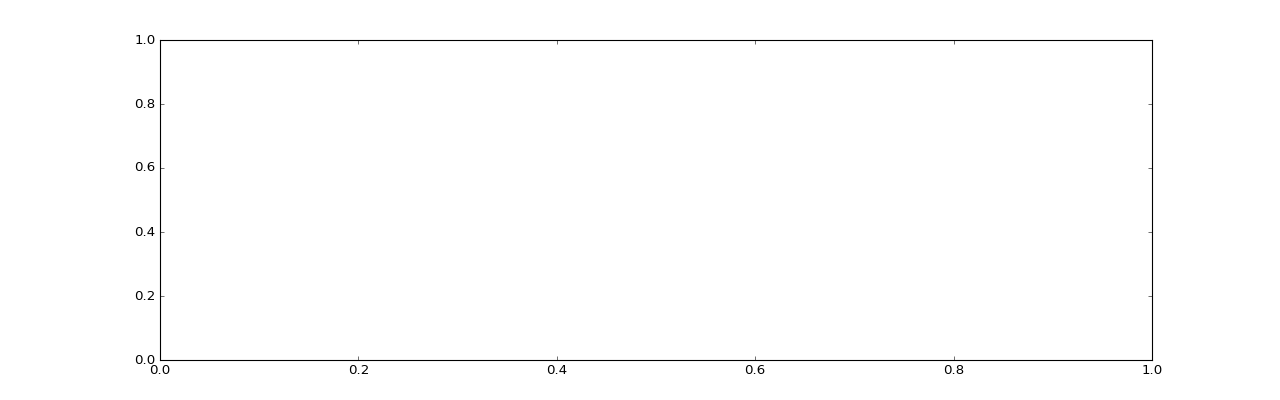

NameError: name 'sns' is not defined

In [102]:
fig, ax = plt.subplots(figsize=(16,5));        # Sample figsize in inches
cor = dfSF_BayHeatmap1.abs()
cor.values[[np.arange(7)]*2] = 0
sns.heatmap(cor,cmap='Oranges');

# PARTE MATIAS

In [388]:
latPromedio = dfEstaciones.lat.mean()
longPromedio = dfEstaciones.long.mean()
cantidadTotalDeBicicletasSoportadas = dfEstaciones.dock_count.sum()
print cantidadTotalDeBicicletasSoportadas

1236


In [389]:
map1 = folium.Map(location=[latPromedio, longPromedio], tiles = "Stamen Terrain")
map1Copy = folium.Map(location=[latPromedio, longPromedio], tiles = "Stamen Terrain")
map2 = folium.Map(location=[latPromedio, longPromedio], tiles = "Stamen Terrain")
startStationMap = folium.Map(location=[latPromedio, longPromedio], tiles = "Stamen Terrain")
viajesEntreEstacionesMap = folium.Map(location=[latPromedio, longPromedio], tiles = "Stamen Terrain")

In [227]:
grupoDeUbicaciones = folium.FeatureGroup(name='Ubicación de estaciones 1')
for lat, lon, nombre in zip(dfEstaciones.lat, dfEstaciones.long, dfEstaciones.name):
    grupoDeUbicaciones.add_child(folium.Marker(location=[lat,lon], popup=nombre))
    
map1.add_child(grupoDeUbicaciones)

In [228]:
# Ahora intento version con MarkerCluster
# map1Copy.add_child(folium.MarkerCluster(locations=list(zip(dfEstaciones.long, dfEstaciones.lat))))

clusterDeUbicaciones = folium.MarkerCluster().add_to(map1Copy)
for lat, lon, nombre in zip(dfEstaciones.lat, dfEstaciones.long, dfEstaciones.name):
    folium.Marker(location=[lat,lon], popup=nombre).add_to(clusterDeUbicaciones)
    
# map1.add_child(grupoDeUbicaciones)
map1Copy

In [229]:
grupoDeUbicacionesConCantidades = folium.FeatureGroup(name='Ubicación de estaciones')
for lat, lon, nombre, cantidadDeBicicletasSoportadas in zip(dfEstaciones.lat, dfEstaciones.long, dfEstaciones.name, dfEstaciones.dock_count):
    grupoDeUbicacionesConCantidades.add_child(folium.CircleMarker(location=[lat,lon], popup=nombre, 
                                                     radius=cantidadDeBicicletasSoportadas, 
                                                     fill_color='#b3ffb3', color='#00ff00'))
    
map2.add_child(grupoDeUbicacionesConCantidades)

In [230]:
dfStartStationCount = dfViajes[['id', 'start_station_id']].groupby(by='start_station_id', as_index=False)\
                                                .count().rename(columns={'id': 'cantidad_de_partidas'})
dfStartStationCount

start_station_id  cantidad_de_partidas
0                  2                  9558
1                  3                  1594
2                  4                  3861
3                  5                  1257
4                  6                  2917
5                  7                  2233
6                  8                  1692
7                  9                  1910
8                 10                  2393
9                 11                  2034
10                12                  1170
11                13                  1680
12                14                  1496
13                16                  1473
14                21                   224
15                22                  1554
16                23                   287
17                24                   213
18                25                   503
19                26                   311
20                27                  2984
21                28                  6544
22                29                  1990
23                30                  1667
24                31                  1818
25                32                  2035
26                33                  1129
27                34                  2111
28                35                  1512
29                36                  1026
..               ...                   ...
40                50                 32934
41                51                 14054
42                54                 14811
43                55                 26089
44                56                 15709
45                57                 13526
46                58                  4535
47                59                  7342
48                60                 27713
49                61                 25837
50                62                 15940
51                63                 13163
52                64                 18496
53                65                 23724
54                66                 12880
55                67                 20272
56                68                 11251
57                69                 33742
58                70                 49092
59                71                 12496
60                72                 14102
61                73                 16306
62                74                 24838
63                75                 12224
64                76                 20165
65                77                 24172
66                80                   863
67                82                 10310
68                83                   341
69                84                  1747

[70 rows x 2 columns]

In [231]:
dfPartidas = dfEstaciones[['id', 'lat', 'long', 'name']].merge(pd.DataFrame(dfStartStationCount), \
         left_on='id', right_on='start_station_id', how='right')
dfPartidas

id        lat        long                                           name  \
0    2  37.329732 -121.901782              San Jose Diridon Caltrain Station   
1    3  37.330698 -121.888979                          San Jose Civic Center   
2    4  37.333988 -121.894902                         Santa Clara at Almaden   
3    5  37.331415 -121.893200                               Adobe on Almaden   
4    6  37.336721 -121.894074                               San Pedro Square   
5    7  37.333798 -121.886943                           Paseo de San Antonio   
6    8  37.330165 -121.885831                            San Salvador at 1st   
7    9  37.348742 -121.894715                                      Japantown   
8   10  37.337391 -121.886995                             San Jose City Hall   
9   11  37.335885 -121.885660                                    MLK Library   
10  12  37.332808 -121.883891                         SJSU 4th at San Carlos   
11  13  37.339301 -121.889937                                  St James Park   
12  14  37.332692 -121.900084                       Arena Green / SAP Center   
13  16  37.333955 -121.877349                     SJSU - San Salvador at 9th   
14  21  37.481758 -122.226904                              Franklin at Maple   
15  22  37.486078 -122.232089                  Redwood City Caltrain Station   
16  23  37.487616 -122.229951                        San Mateo County Center   
17  24  37.484219 -122.227424                    Redwood City Public Library   
18  25  37.485370 -122.203288                       Stanford in Redwood City   
19  26  37.487682 -122.223492                    Redwood City Medical Center   
20  27  37.389218 -122.081896                        Mountain View City Hall   
21  28  37.394358 -122.076713                 Mountain View Caltrain Station   
22  29  37.406940 -122.106758                   San Antonio Caltrain Station   
23  30  37.390277 -122.066553                           Evelyn Park and Ride   
24  31  37.400443 -122.108338                    San Antonio Shopping Center   
25  32  37.385956 -122.083678               Castro Street and El Camino Real   
26  33  37.400241 -122.099076          Rengstorff Avenue / California Street   
27  34  37.443988 -122.164759                     Palo Alto Caltrain Station   
28  35  37.444521 -122.163093                         University and Emerson   
29  36  37.429082 -122.142805                California Ave Caltrain Station   
..  ..        ...         ...                                            ...   
40  51  37.791464 -122.391034                          Embarcadero at Folsom   
41  39  37.783871 -122.408433                             Powell Street BART   
42  54  37.787152 -122.388013                          Embarcadero at Bryant   
43  55  37.789756 -122.394643  Temporary Transbay Terminal (Howard at Beale)   
44  56  37.792251 -122.397086                                Beale at Market   
45  57  37.781752 -122.405127                                  5th at Howard   
46  58  37.778650 -122.418235                        San Francisco City Hall   
47  59  37.781332 -122.418603                            Golden Gate at Polk   
48  60  37.804770 -122.403234                         Embarcadero at Sansome   
49  61  37.780526 -122.390288                                2nd at Townsend   
50  62  37.785299 -122.396236                                  2nd at Folsom   
51  63  37.786978 -122.398108                                  Howard at 2nd   
52  64  37.782259 -122.392738                              2nd at South Park   
53  65  37.771058 -122.402717                                Townsend at 7th   
54  66  37.774814 -122.418954                       South Van Ness at Market   
55  67  37.776619 -122.417385                                 Market at 10th   
56  68  37.784878 -122.401014  Yerba Buena Center of the Arts (3rd @ Howard)   
57  69  37.776600 -122.395470        San Francisco Caltrain 2 (330 Townsend)   
58  

In [232]:
cantidad_de_partidas_maxima = dfPartidas.cantidad_de_partidas.max()
cantidad_de_partidas_maxima

49092

In [233]:
grupoDeUbicacionesConCantidadesDePartidas = folium.FeatureGroup(name='Ubicación de estaciones con infor de #partidas')
for lat, lon, nombre, cant in zip(dfPartidas.lat, dfPartidas.long, dfPartidas.name, dfPartidas.cantidad_de_partidas):
    grupoDeUbicacionesConCantidadesDePartidas.add_child(folium.CircleMarker(location=[lat,lon], popup=nombre, 
                                                     radius=cant/1000,
                                                     fill_color='#8A2BE2', color='#00ff00'))
    
startStationMap.add_child(grupoDeUbicacionesConCantidadesDePartidas)

In [234]:
# df = pd.DataFrame(columns=['start_station_id', 'start_station_lat', 'start_station_lon',
#                            'end_station_id', 'end_station_lat', 'end_station_lon'])
# df.start_station_id = dfViajes.start_station_id
# df
# dfStartStationCount['start_station_lat'] = dfEstaciones['lat']
# dfStartStationCount['start_station_lon'] = dfEstaciones['long']
# dfStartStationCount['name'] = dfEstaciones['name']
# for idEstacionSalida in dfStartStationCount.index.tolist():
#     dfStartStationCount['start_station_lat'] = dfEstaciones.loc[dfEstaciones.id == idEstacionSalida, 'lat'] 
# dfStartStationCount

In [235]:
# grupoDeUbicacionesConCantidades = folium.FeatureGroup(name='Ubicación de estaciones')
# for lat, lon, nombre, cantidadDeBicicletasSoportadas in zip(dfEstaciones.lat, dfEstaciones.long, dfEstaciones.name, dfEstaciones.dock_count):
#     grupoDeUbicacionesConCantidades.add_child(folium.CircleMarker(location=[lat,lon], popup=nombre, 
#                                                      radius=cantidadDeBicicletasSoportadas, 
#                                                      fill_color='#b3ffb3', color='#00ff00'))
    
# map2.add_child(grupoDeUbicacionesConCantidades)

In [390]:
dfViajesEntreEstaciones = dfViajes[['id', 'start_station_id', 'end_station_id']]\
        .groupby(by=['start_station_id', 'end_station_id'], as_index=False)\
        .count().rename(columns={'id': 'cantidad'})
dfViajesEntreEstaciones

start_station_id  end_station_id  cantidad
0                    2               2       191
1                    2               3       448
2                    2               4      2200
3                    2               5       627
4                    2               6      1274
5                    2               7      1007
6                    2               8       228
7                    2               9       634
8                    2              10       519
9                    2              11       808
10                   2              12       190
11                   2              13       595
12                   2              14        35
13                   2              16       392
14                   2              28         3
15                   2              33         1
16                   2              37         1
17                   2              80        23
18                   2              84       382
19                   3               2       381
20                   3               3       391
21                   3               4       118
22                   3               5        53
23                   3               6       107
24                   3               7        55
25                   3               8        36
26                   3               9        29
27                   3              10        92
28                   3              11       101
29                   3              12        54
...                ...             ...       ...
1721                82              73        86
1722                82              74       869
1723                82              75       784
1724                82              76       212
1725                82              77       545
1726                82              82       238
1727                83              22       270
1728                83              23        12
1729                83              24        14
1730                83              25         2
1731                83              26         4
1732                83              34         2
1733                83              36         1
1734                83              83        36
1735                84               2       546
1736                84               3       161
1737                84               4        23
1738                84               5        12
1739                84               6       141
1740                84               7        42
1741                84               8        13
1742                84               9        99
1743                84              10        19
1744                84              11        41
1745                84              12        47
1746                84              13        15
1747                84              14        32
1748                84              16         5
1749                84              80       427
1750                84              84       124

[1751 rows x 3 columns]

In [391]:
dfViajesEntreEstaciones = dfViajesEntreEstaciones.merge(right=dfEstaciones[['lat', 'long', 'id', 'name', 'city']], \
                              left_on='start_station_id', right_on='id')\
                            .drop(['id'], 1).rename(columns={'lat': 'start_station_lat', 'long': \
                                                          'start_station_long', 'name': 'start_station_name', \
                                                             'city': 'start_city'})

In [392]:
dfViajesEntreEstaciones = dfViajesEntreEstaciones.merge(right=dfEstaciones[['lat', 'long', 'id', 'name', 'city']], \
                              left_on='end_station_id', right_on='id')\
                            .drop(['id'], 1).rename(columns={'lat': 'end_station_lat', 'long': \
                                                          'end_station_long', 'name': 'end_station_name', \
                                                             'city': 'end_city'})
dfViajesEntreEstaciones.sort_values(by='cantidad', ascending=True)

start_station_id  end_station_id  cantidad  start_station_lat  \
200                 28              13         1          37.394358   
548                 26              83         1          37.487682   
355                  4              70         1          37.333988   
357                 28              70         1          37.394358   
358                 31              70         1          37.400443   
267                  2              37         1          37.329732   
361                 36              70         1          37.429082   
362                 38              70         1          37.425684   
549                 56              83         1          37.792251   
541                 39              35         1          37.783871   
254                  5              33         1          37.331415   
528                 23              35         1          37.487616   
601                 34              32         1          37.443988   
524                 66              34         1          37.774814   
513                 24              34         1          37.484219   
398                  7              76         1          37.333798   
399                 11              76         1          37.335885   
150                 58              10         1          37.778650   
551                 22              29         1          37.486078   
271                 23              37         1          37.487616   
735                 36              77         1          37.429082   
132                 28               9         1          37.394358   
699                 36              56         1          37.429082   
115                 29               8         1          37.406940   
593                 24              32         1          37.484219   
278                 32              37         1          37.385956   
581                 23              38         1          37.487616   
317                  3              72         1          37.330698   
318                 22              72         1          37.486078   
319                 31              72         1          37.400443   
...                ...             ...       ...                ...   
762                 70              77      2598          37.776617   
605                 28              27      2666          37.394358   
1464                72              65      2672          37.781039   
341                 65              72      2698          37.771058   
395                 76              70      2797          37.786305   
1541                39              69      2854          37.783871   
1672                70              74      2866          37.776617   
1663                61              74      2877          37.780526   
1216                69              57      3005          37.776600   
1112                70              51      3031          37.776617   
371                 50              70      3033          37.795392   
1326                74              60      3116          37.794139   
386                 67              70      3190          37.776619   
1067                60              50      3231          37.804770   
1434                77              64      3427          37.789625   
796                 69              39      3438          37.776600   
393                 74              70      3477          37.794139   
1562                65              69      3495          37.771058   
1182                70              55      3510          37.776617   
374                 55              70      3526          37.789756   
1077                70              50      3622          37.776617   
756                 64              77      3627          37.782259   
1361                74              61      3903          37.794139   
372                 51              70      3967          37.791464   
1662                60        

In [393]:
dfViajesEntreEstaciones.cantidad.describe()

count    1751.000000
mean      382.615077
std       592.419146
min         1.000000
25%        71.500000
50%       191.000000
75%       440.000000
max      6216.000000
Name: cantidad, dtype: float64

## Analizo distribucion de datos

In [429]:
import seaborn as sns

ImportError: No module named seaborn

<IPython.core.display.Javascript object>


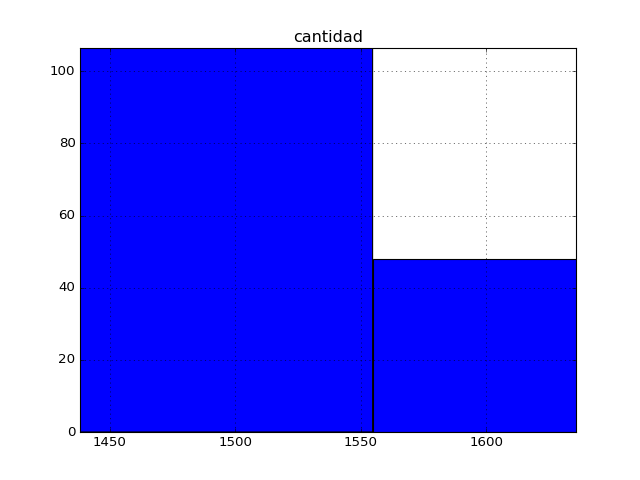

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff58c0a9ad0>]], dtype=object)

In [428]:
dfViajesEntreEstaciones.filter().hist('cantidad', bins=4)

In [394]:
maxCantidadDeViajes = dfViajesEntreEstaciones.cantidad.max()
promedioCantidadDeViajes = dfViajesEntreEstaciones.cantidad.mean()
dfViajesEntreEstaciones.cantidad.max()

6216

In [430]:
# colores = cm.LinearColormap(['green', 'orange', 'red'], vmax=maxCantidadDeViajes, 
#                   index=[0, promedioCantidadDeViajes, maxCantidadDeViajes])

# colores = cm.LinearColormap(['red', 'orange', 'yellow', 'green'], vmax = maxCantidadDeViajes)

colores = cm.StepColormap(['green', 'yellow', 'magenta', 'red'],
                       vmin=1, vmax=maxCantidadDeViajes, index=[1, 1500, 3100, 4650, maxCantidadDeViajes],
                       caption='step')
colores.caption = 'Cantidad de viajes entre estaciones'
# colores = cm.linear.Set1.scale(0, maxCantidadDeViajes).to_step(
# #     n=4,
#     index=[1, 71.5, 191, 440, 6216],
# #     method='quantiles',
# #     round_method='int'
# )
# colores.to_linear()
colores2 = cm.linear.YlGn.scale(0, 6000)
#colores3 = cm.linear.RdGy.to_step(100).scale(0, 6000)


colores

In [431]:
linesMap = folium.Map(location=[latPromedio, longPromedio], tiles = "Stamen Terrain")
linesMap.add_child(colores)

In [432]:
clusterDeUbicaciones = folium.MarkerCluster().add_to(linesMap)
for lat, lon, nombre in zip(dfEstaciones.lat, dfEstaciones.long, dfEstaciones.name):
    folium.Marker(location=[lat,lon], popup=nombre).add_to(clusterDeUbicaciones)

In [433]:
for startLat, startLon, startName, endLat, endLon, endName, cant in zip(dfViajesEntreEstaciones.start_station_lat,\
                                                                       dfViajesEntreEstaciones.start_station_long,\
                                                                       dfViajesEntreEstaciones.start_station_name,\
                                                                       dfViajesEntreEstaciones.end_station_lat,\
                                                                       dfViajesEntreEstaciones.end_station_long,\
                                                                       dfViajesEntreEstaciones.end_station_name,\
                                                                       dfViajesEntreEstaciones.cantidad):
    folium.PolyLine(locations=[(startLat, startLon), (endLat, endLon)], color=colores(cant), weight=3, opacity=1).add_to(linesMap)
#     linesMap.add_child(c)
    
# startStationMap.add_child(grupoDeViajesEntreEstaciones)
linesMap

In [246]:
dfViajesEntreEstaciones.start_city.unique()

array(['San Jose', 'Mountain View', 'San Francisco', 'Redwood City',
       'Palo Alto'], dtype=object)

# Mapa con viajes en San Jose

In [247]:
dfViajesEntreEstacionesEnSanJose = (dfViajesEntreEstaciones[dfViajesEntreEstaciones.start_city == 'San Jose']).drop('start_city', 1)
dfViajesEntreEstacionesEnSanJose = (dfViajesEntreEstacionesEnSanJose[dfViajesEntreEstacionesEnSanJose.end_city == 'San Jose']).drop('end_city', 1)
dfViajesEntreEstacionesEnSanJose

start_station_id  end_station_id  cantidad  start_station_lat  \
0                   2               2       191          37.329732   
1                   3               2       381          37.330698   
2                   4               2      2283          37.333988   
3                   5               2       687          37.331415   
4                   6               2      1172          37.336721   
5                   7               2       695          37.333798   
6                   8               2       261          37.330165   
7                   9               2       438          37.348742   
8                  10               2       716          37.337391   
9                  11               2       806          37.335885   
10                 12               2       125          37.332808   
11                 13               2       645          37.339301   
12                 14               2        37          37.332692   
13                 16               2       410          37.333955   
17                 80               2        17          37.352601   
18                 84               2       546          37.342725   
19                  2               3       448          37.329732   
20                  3               3       391          37.330698   
21                  4               3        78          37.333988   
22                  5               3        49          37.331415   
23                  6               3       122          37.336721   
24                  7               3        59          37.333798   
25                  8               3        51          37.330165   
26                  9               3        62          37.348742   
27                 10               3       118          37.337391   
28                 11               3        71          37.335885   
29                 12               3        58          37.332808   
30                 13               3        25          37.339301   
31                 14               3        49          37.332692   
32                 16               3        34          37.333955   
..                ...             ...       ...                ...   
286                 4              80        10          37.333988   
287                 5              80         9          37.331415   
288                 6              80       100          37.336721   
289                 7              80         5          37.333798   
290                 8              80         6          37.330165   
291                 9              80        46          37.348742   
292                10              80        19          37.337391   
293                11              80        14          37.335885   
294                12              80         9          37.332808   
295                13              80        22          37.339301   
296                14              80        79          37.332692   
297                16              80        11          37.333955   
299                80              80        67          37.352601   
300                84              80       427          37.342725   
301                 2              84       382          37.329732   
302                 3              84        41          37.330698   
303                 4              84        14          37.333988   
304                 5              84         4          37.331415   
305                 6              84       162          37.336721   
306                 7              84        43          37.333798   
307                 8              84        17          37.330165   
308                 9              84       121          37.348742   
309                10              84        15          37.337391   
310                11              84        37          37.335885   
311                12              84        21          37.332808   
312            

In [248]:
latSanJosePromedio = dfViajesEntreEstacionesEnSanJose.start_station_lat.mean()
longSanJosePromedio = dfViajesEntreEstacionesEnSanJose.start_station_long.mean()

In [249]:
viajesEntreEstacionesEnSanJoseMap = folium.Map(location=[latSanJosePromedio, longSanJosePromedio], tiles = "Stamen Terrain", zoom_start=14)
viajesEntreEstacionesEnSanJoseMap

In [250]:
dfViajesEntreEstacionesEnSanJose.cantidad.describe()

count     256.000000
mean      147.875000
std       265.645023
min         3.000000
25%        32.000000
50%        65.000000
75%       135.250000
max      2283.000000
Name: cantidad, dtype: float64

In [251]:
maxCantidadDeViajesEnSanJose = dfViajesEntreEstacionesEnSanJose.cantidad.max()
# promedioCantidadDeViajesEnSanJose = dfViajesEntreEstacionesEnSanJose.cantidad.mean()

In [252]:
coloresSanJose = cm.StepColormap(['green', 'yellow', 'magenta', 'red'],
                       vmin=1, vmax=maxCantidadDeViajesEnSanJose, index=[3, 32, 65, 135, maxCantidadDeViajesEnSanJose],
                       caption='step')
coloresSanJose.caption = 'Cantidad de viajes entre estaciones en San Jose'
coloresSanJose
coloresSanJose2 = cm.linear.YlGn.scale(0, maxCantidadDeViajesEnSanJose)

In [253]:
viajesEntreEstacionesEnSanJoseMap.add_child(coloresSanJose)

In [254]:
clusterDeUbicacionesSanJose = folium.MarkerCluster().add_to(viajesEntreEstacionesEnSanJoseMap)
for lat, lon, nombre in zip(dfViajesEntreEstacionesEnSanJose.start_station_lat.unique(), \
                            dfViajesEntreEstacionesEnSanJose.start_station_long.unique(), \
                            dfViajesEntreEstacionesEnSanJose.start_station_name.unique()):
    folium.Marker(location=[lat,lon], popup=nombre).add_to(clusterDeUbicacionesSanJose)

In [255]:
for startLat, startLon, startName, endLat, endLon, endName, cant in zip(dfViajesEntreEstacionesEnSanJose.start_station_lat,\
                                                                       dfViajesEntreEstacionesEnSanJose.start_station_long,\
                                                                       dfViajesEntreEstacionesEnSanJose.start_station_name,\
                                                                       dfViajesEntreEstacionesEnSanJose.end_station_lat,\
                                                                       dfViajesEntreEstacionesEnSanJose.end_station_long,\
                                                                       dfViajesEntreEstacionesEnSanJose.end_station_name,\
                                                                       dfViajesEntreEstacionesEnSanJose.cantidad):
    folium.PolyLine(locations=[(startLat, startLon), (endLat, endLon)], color=coloresSanJose(cant), weight=3, opacity=1).add_to(viajesEntreEstacionesEnSanJoseMap)
viajesEntreEstacionesEnSanJoseMap

### Grafico con n estaciones mas activas

In [478]:
n = 20

In [479]:
cotaInferiorSanJose = dfViajesEntreEstacionesEnSanJose.cantidad.nlargest (n).min()

In [480]:
dfViajesEntreEstacionesEnSanJoseTopN = dfViajesEntreEstacionesEnSanJose[dfViajesEntreEstacionesEnSanJose['cantidad'] \
                                                                        >= cotaInferiorSanJose]
dfViajesEntreEstacionesEnSanJoseTopN

start_station_id  end_station_id  cantidad  start_station_lat  \
2                   4               2      2283          37.333988   
3                   5               2       687          37.331415   
4                   6               2      1172          37.336721   
5                   7               2       695          37.333798   
7                   9               2       438          37.348742   
8                  10               2       716          37.337391   
9                  11               2       806          37.335885   
11                 13               2       645          37.339301   
18                 84               2       546          37.342725   
19                  2               3       448          37.329732   
36                  2               4      2200          37.329732   
48                 14               4       542          37.332692   
52                  2               5       627          37.329732   
68                  2               6      1274          37.329732   
84                  2               7      1007          37.329732   
118                 2               9       634          37.329732   
136                 2              10       519          37.329732   
153                 2              11       808          37.329732   
185                 2              13       595          37.329732   
205                 4              14       554          37.333988   

     start_station_long                 start_station_name  end_station_lat  \
2           -121.894902             Santa Clara at Almaden        37.329732   
3           -121.893200                   Adobe on Almaden        37.329732   
4           -121.894074                   San Pedro Square        37.329732   
5           -121.886943               Paseo de San Antonio        37.329732   
7           -121.894715                          Japantown        37.329732   
8           -121.886995                 San Jose City Hall        37.329732   
9           -121.885660                        MLK Library        37.329732   
11          -121.889937                      St James Park        37.329732   
18          -121.895617                        Ryland Park        37.329732   
19          -121.901782  San Jose Diridon Caltrain Station        37.330698   
36          -121.901782  San Jose Diridon Caltrain Station        37.333988   
48          -121.900084           Arena Green / SAP Center        37.333988   
52          -121.901782  San Jose Diridon Caltrain Station        37.331415   
68          -121.901782  San Jose Diridon Caltrain Station        37.336721   
84          -121.901782  San Jose Diridon Caltrain Station        37.333798   
118         -121.901782  San Jose Diridon Caltrain Station        37.348742   
136         -121.901782  San Jose Diridon Caltrain Station        37.337391   
153         -121.901782  San Jose Diridon Caltrain Station        37.335885   
185         -121.901782  San Jose Diridon Caltrain Station        37.339301   
205         -121.894902             Santa Clara at Almaden        37.332692   

     end_station_long                   end_station_name  
2         -121.901782  San Jose Diridon Caltrain Station  
3         -121.901782  San Jose Diridon Caltrain Station  
4         -121.901782  San Jose Diridon Caltrain Station  
5         -121.901782  San Jose Diridon Caltrain Station  
7         -121.901782  San Jose Diridon Caltrain Station  
8         -121.901782  San Jose Diridon Caltrain Station  
9         -121.901782  San Jose Diridon Caltrain Station  
11        -121.901782  San Jose Diridon Caltrain Station  
18        -121.901782  San Jose Diridon Caltrain Station  
19        -121.888979              San Jose Civic Center  
36        -121.894902             Santa Clara at Almaden  
48        -121.894902             Santa Clara at Almaden  
52        -121.893200                   Adobe on Almaden  
68        -121.894074                   San Pedr

In [481]:
topViajesEntreEstacionesEnSanJoseMap = folium.Map(location=[latSanJosePromedio, longSanJosePromedio], tiles = "Stamen Terrain", zoom_start=14)
topViajesEntreEstacionesEnSanJoseMap

In [482]:
dfViajesEntreEstacionesEnSanJoseTopN.cantidad.describe()

count      20.000000
mean      859.800000
std       521.822071
min       438.000000
25%       552.000000
50%       666.000000
75%       857.750000
max      2283.000000
Name: cantidad, dtype: float64

In [484]:
coloresSanJoseTopN = cm.StepColormap(['green', 'yellow', 'magenta', 'red'],
                       vmin=1, vmax=maxCantidadDeViajesEnSanJose, index=[438, 552, 666, 857, maxCantidadDeViajesEnSanJose],
                       caption='step')
coloresSanJoseTopN.caption = 'Cantidad de viajes entre estaciones en San Jose'

coloresSanJoseTopN2 = cm.linear.YlGn.scale(0, maxCantidadDeViajesEnSanJose)

coloresSanJoseTopN

In [485]:
topViajesEntreEstacionesEnSanJoseMap.add_child(coloresSanJoseTopN)

In [486]:
clusterDeUbicacionesSanJose = folium.MarkerCluster().add_to(topViajesEntreEstacionesEnSanJoseMap)
for lat, lon, nombre in zip(dfViajesEntreEstacionesEnSanJose.start_station_lat.unique(), \
                            dfViajesEntreEstacionesEnSanJose.start_station_long.unique(), \
                            dfViajesEntreEstacionesEnSanJose.start_station_name.unique()):
    folium.Marker(location=[lat,lon], popup=nombre).add_to(clusterDeUbicacionesSanJose)

In [488]:
for startLat, startLon, startName, endLat, endLon, endName, cant in zip(dfViajesEntreEstacionesEnSanJoseTopN.start_station_lat,\
                                                                       dfViajesEntreEstacionesEnSanJoseTopN.start_station_long,\
                                                                       dfViajesEntreEstacionesEnSanJoseTopN.start_station_name,\
                                                                       dfViajesEntreEstacionesEnSanJoseTopN.end_station_lat,\
                                                                       dfViajesEntreEstacionesEnSanJoseTopN.end_station_long,\
                                                                       dfViajesEntreEstacionesEnSanJoseTopN.end_station_name,\
                                                                       dfViajesEntreEstacionesEnSanJoseTopN.cantidad):
    folium.PolyLine(locations=[(startLat, startLon), (endLat, endLon)], color=coloresSanJose(cant), weight=5, opacity=1).add_to(topViajesEntreEstacionesEnSanJoseMap)
topViajesEntreEstacionesEnSanJoseMap

# Mapa con viajes en Mountain View

In [289]:
dfViajesEntreEstacionesEnMountainView = (dfViajesEntreEstaciones[dfViajesEntreEstaciones.start_city == 'Mountain View']).drop('start_city', 1)
dfViajesEntreEstacionesEnMountainView = (dfViajesEntreEstacionesEnMountainView[dfViajesEntreEstacionesEnMountainView.end_city == 'Mountain View']).drop('end_city', 1)
dfViajesEntreEstacionesEnMountainView

start_station_id  end_station_id  cantidad  start_station_lat  \
241                27              28      2401          37.389218   
242                28              28       528          37.394358   
243                29              28       105          37.406940   
244                30              28      1337          37.390277   
245                31              28       176          37.400443   
246                32              28      1677          37.385956   
247                33              28       430          37.400241   
255                27              33       108          37.389218   
256                28              33       399          37.394358   
257                29              33       280          37.406940   
258                30              33         8          37.390277   
259                31              33        71          37.400443   
260                32              33        16          37.385956   
261                33              33       160          37.400241   
437                27              31        67          37.389218   
438                28              31       187          37.394358   
439                29              31      1272          37.406940   
440                30              31         4          37.390277   
441                31              31        75          37.400443   
442                32              31        47          37.385956   
443                33              31        63          37.400241   
552                27              29        44          37.389218   
553                28              29       140          37.394358   
554                29              29       133          37.406940   
555                30              29         6          37.390277   
556                31              29      1278          37.400443   
557                32              29        12          37.385956   
558                33              29       280          37.400241   
594                27              32        77          37.389218   
595                28              32      1490          37.394358   
596                29              32         8          37.406940   
597                30              32        30          37.390277   
598                31              32        26          37.400443   
599                32              32       161          37.385956   
600                33              32        17          37.400241   
604                27              27       197          37.389218   
605                28              27      2666          37.394358   
606                29              27        41          37.406940   
607                30              27       101          37.390277   
608                31              27        50          37.400443   
609                32              27        89          37.385956   
610                33              27       125          37.400241   
615                27              30        64          37.389218   
616                28              30      1082          37.394358   
617                29              30         7          37.406940   
618                30              30       180          37.390277   
619                31              30         2          37.400443   
620                32              30        24          37.385956   
621                33              30         5          37.400241   

     start_station_long                     start_station_name  \
241         -122.081896                Mountain View City Hall   
242         -122.076713         Mountain View Caltrain Station   
243         -122.106758           San Antonio Caltrain Station   
244         -122.066553                   Evelyn Park and Ride   
245         -122.108338            San Antonio Shopping Center   
246         -122.083678       Castro Street and El Camino Real   
247         -122.099076  Rengstorff Avenue

In [290]:
latMountainViewPromedio = dfViajesEntreEstacionesEnMountainView.start_station_lat.mean()
longMountainViewPromedio = dfViajesEntreEstacionesEnMountainView.start_station_long.mean()

In [291]:
viajesEntreEstacionesEnMountainViewMap = folium.Map(location=[latMountainViewPromedio, longMountainViewPromedio], tiles = "Stamen Terrain", zoom_start=14)
viajesEntreEstacionesEnMountainViewMap

In [292]:
dfViajesEntreEstacionesEnMountainView.cantidad.describe()

count      49.000000
mean      362.163265
std       625.667255
min         2.000000
25%        30.000000
50%       101.000000
75%       280.000000
max      2666.000000
Name: cantidad, dtype: float64

In [293]:
maxCantidadDeViajesEnMountainView = dfViajesEntreEstacionesEnMountainView.cantidad.max()

In [294]:
coloresMountainView = cm.StepColormap(['green', 'yellow', 'magenta', 'red'],
                       vmin=1, vmax=maxCantidadDeViajesEnMountainView, index=[2, 30, 101, 280, maxCantidadDeViajesEnMountainView],
                       caption='step')
coloresMountainView.caption = 'Cantidad de viajes entre estaciones en Mountain View'
coloresMountainView
coloresSanJose2 = cm.linear.YlGn.scale(0, maxCantidadDeViajesEnMountainView)

In [295]:
viajesEntreEstacionesEnMountainViewMap.add_child(coloresMountainView)

In [296]:
clusterDeUbicacionesMountainView = folium.MarkerCluster().add_to(viajesEntreEstacionesEnMountainViewMap)
for lat, lon, nombre in zip(dfViajesEntreEstacionesEnMountainView.start_station_lat.unique(), \
                            dfViajesEntreEstacionesEnMountainView.start_station_long.unique(), \
                            dfViajesEntreEstacionesEnMountainView.start_station_name.unique()):
    folium.Marker(location=[lat,lon], popup=nombre).add_to(clusterDeUbicacionesMountainView)

In [297]:
for startLat, startLon, startName, endLat, endLon, endName, cant in zip(dfViajesEntreEstacionesEnMountainView.start_station_lat,\
                                                                       dfViajesEntreEstacionesEnMountainView.start_station_long,\
                                                                       dfViajesEntreEstacionesEnMountainView.start_station_name,\
                                                                       dfViajesEntreEstacionesEnMountainView.end_station_lat,\
                                                                       dfViajesEntreEstacionesEnMountainView.end_station_long,\
                                                                       dfViajesEntreEstacionesEnMountainView.end_station_name,\
                                                                       dfViajesEntreEstacionesEnMountainView.cantidad):
    folium.PolyLine(locations=[(startLat, startLon), (endLat, endLon)], color=coloresMountainView(cant), weight=3, opacity=1).add_to(viajesEntreEstacionesEnMountainViewMap)
viajesEntreEstacionesEnMountainViewMap

# Mapa con viajes en San Francisco

In [298]:
dfViajesEntreEstacionesEnSanFrancisco = (dfViajesEntreEstaciones[dfViajesEntreEstaciones.start_city == 'San Francisco']).drop('start_city', 1)
dfViajesEntreEstacionesEnSanFrancisco = (dfViajesEntreEstacionesEnSanFrancisco[dfViajesEntreEstacionesEnSanFrancisco.end_city == 'San Francisco']).drop('end_city', 1)
dfViajesEntreEstacionesEnSanFrancisco

start_station_id  end_station_id  cantidad  start_station_lat  \
320                 39              72       774          37.783871   
321                 41              72       161          37.795001   
322                 42              72       110          37.797280   
323                 45              72       163          37.794231   
324                 46              72       100          37.795425   
325                 47              72       219          37.788975   
326                 48              72       112          37.799953   
327                 49              72        97          37.790302   
328                 50              72       171          37.795392   
329                 51              72        52          37.791464   
330                 54              72        64          37.787152   
331                 55              72       605          37.789756   
332                 56              72       164          37.792251   
333                 57              72       460          37.781752   
334                 58              72       142          37.778650   
335                 59              72       370          37.781332   
336                 60              72       415          37.804770   
337                 61              72       141          37.780526   
338                 62              72       179          37.785299   
339                 63              72       193          37.786978   
340                 64              72       164          37.782259   
341                 65              72      2698          37.771058   
342                 66              72      1258          37.774814   
343                 67              72       836          37.776619   
344                 68              72       218          37.784878   
345                 69              72       853          37.776600   
346                 70              72       708          37.776617   
347                 71              72       332          37.788446   
348                 72              72       436          37.781039   
349                 73              72       213          37.798522   
...                ...             ...       ...                ...   
1721                47              82       217          37.788975   
1722                48              82        59          37.799953   
1723                49              82       196          37.790302   
1724                50              82       254          37.795392   
1725                51              82       133          37.791464   
1726                54              82       250          37.787152   
1727                55              82       965          37.789756   
1728                56              82      1254          37.792251   
1729                57              82       128          37.781752   
1730                58              82        20          37.778650   
1731                59              82        12          37.781332   
1732                60              82       318          37.804770   
1733                61              82       371          37.780526   
1734                62              82       101          37.785299   
1735                63              82        62          37.786978   
1736                64              82       101          37.782259   
1737                65              82        81          37.771058   
1738                66              82        30          37.774814   
1739                67              82        45          37.776619   
1740                68              82        57          37.784878   
1741                69              82       507          37.776600   
1742                70              82       996          37.776617   
1743                71              82       334          37.788446   
1744                72              82        86          37.781039   
1745                73        

In [299]:
latSanFranciscoPromedio = dfViajesEntreEstacionesEnSanFrancisco.start_station_lat.mean()
longSanFranciscoPromedio = dfViajesEntreEstacionesEnSanFrancisco.start_station_long.mean()

In [300]:
viajesEntreEstacionesEnSanFranciscoMap = folium.Map(location=[latSanFranciscoPromedio, longSanFranciscoPromedio], tiles = "Stamen Terrain", zoom_start=14)
viajesEntreEstacionesEnSanFranciscoMap

In [301]:
dfViajesEntreEstacionesEnSanFrancisco.cantidad.describe()

count    1225.000000
mean      492.810612
std       652.207242
min         9.000000
25%       149.000000
50%       284.000000
75%       565.000000
max      6216.000000
Name: cantidad, dtype: float64

In [302]:
maxCantidadDeViajesEnSanFrancisco = dfViajesEntreEstacionesEnSanFrancisco.cantidad.max()

In [303]:
coloresSanFrancisco = cm.StepColormap(['green', 'yellow', 'magenta', 'red'],
                       vmin=1, vmax=maxCantidadDeViajesEnSanFrancisco, index=[9, 149, 284, 565, maxCantidadDeViajesEnSanFrancisco],
                       caption='step')
coloresSanFrancisco.caption = 'Cantidad de viajes entre estaciones en San Francisco'
coloresSanFrancisco
coloresSanFrancisco2 = cm.linear.YlGn.scale(0, maxCantidadDeViajesEnSanFrancisco)

In [304]:
viajesEntreEstacionesEnSanFranciscoMap.add_child(coloresSanFrancisco)

In [305]:
clusterDeUbicacionesSanFrancisco = folium.MarkerCluster().add_to(viajesEntreEstacionesEnSanFranciscoMap)
for lat, lon, nombre in zip(dfViajesEntreEstacionesEnSanFrancisco.start_station_lat.unique(), \
                            dfViajesEntreEstacionesEnSanFrancisco.start_station_long.unique(), \
                            dfViajesEntreEstacionesEnSanFrancisco.start_station_name.unique()):
    folium.Marker(location=[lat,lon], popup=nombre).add_to(clusterDeUbicacionesSanFrancisco)

In [306]:
for startLat, startLon, startName, endLat, endLon, endName, cant in zip(dfViajesEntreEstacionesEnSanFrancisco.start_station_lat,\
                                                                       dfViajesEntreEstacionesEnSanFrancisco.start_station_long,\
                                                                       dfViajesEntreEstacionesEnSanFrancisco.start_station_name,\
                                                                       dfViajesEntreEstacionesEnSanFrancisco.end_station_lat,\
                                                                       dfViajesEntreEstacionesEnSanFrancisco.end_station_long,\
                                                                       dfViajesEntreEstacionesEnSanFrancisco.end_station_name,\
                                                                       dfViajesEntreEstacionesEnSanFrancisco.cantidad):
    folium.PolyLine(locations=[(startLat, startLon), (endLat, endLon)], color=coloresSanFrancisco(cant), weight=3, opacity=1).add_to(viajesEntreEstacionesEnSanFranciscoMap)
viajesEntreEstacionesEnSanFranciscoMap

# Mapa con viajes en Redwood City

In [307]:
dfViajesEntreEstacionesEnRedwoodCity = (dfViajesEntreEstaciones[dfViajesEntreEstaciones.start_city == 'Redwood City']).drop('start_city', 1)
dfViajesEntreEstacionesEnRedwoodCity = (dfViajesEntreEstacionesEnRedwoodCity[dfViajesEntreEstacionesEnRedwoodCity.end_city == 'Redwood City']).drop('end_city', 1)
dfViajesEntreEstacionesEnRedwoodCity

start_station_id  end_station_id  cantidad  start_station_lat  \
450                21              21        38          37.481758   
451                22              21       167          37.486078   
452                23              21         6          37.487616   
453                24              21        22          37.484219   
454                25              21         9          37.485370   
455                26              21         4          37.487682   
460                21              22       117          37.481758   
461                22              22       155          37.486078   
462                23              22        71          37.487616   
463                24              22        68          37.484219   
464                25              22       348          37.485370   
465                26              22       212          37.487682   
472                83              22       270          37.491269   
473                21              23         6          37.481758   
474                22              23       134          37.486078   
475                23              23        84          37.487616   
476                24              23        36          37.484219   
477                25              23        27          37.485370   
478                26              23        48          37.487682   
481                83              23        12          37.491269   
482                21              24        23          37.481758   
483                22              24       110          37.486078   
484                23              24        40          37.487616   
485                24              24        54          37.484219   
486                25              24        18          37.485370   
487                26              24        11          37.487682   
491                83              24        14          37.491269   
492                21              25        17          37.481758   
493                22              25       345          37.486078   
494                23              25        35          37.487616   
495                24              25        14          37.484219   
496                25              25        65          37.485370   
497                26              25        11          37.487682   
503                83              25         2          37.491269   
504                21              26         3          37.481758   
505                22              26       371          37.486078   
506                23              26        38          37.487616   
507                24              26         5          37.484219   
508                25              26        10          37.485370   
509                26              26        21          37.487682   
510                83              26         4          37.491269   
543                21              83         4          37.481758   
544                22              83       223          37.486078   
545                23              83        10          37.487616   
546                24              83         8          37.484219   
547                25              83         2          37.485370   
548                26              83         1          37.487682   
550                83              83        36          37.491269   

     start_station_long             start_station_name  end_station_lat  \
450         -122.226904              Franklin at Maple        37.481758   
451         -122.232089  Redwood City Caltrain Station        37.481758   
452         -122.229951        San Mateo County Center        37.481758   
453         -122.227424    Redwood City Public Library        37.481758   
454         -122.203288       Stanford in Redwood City        37.481758   
455         -122.223492    Redwood City Medical Center        37.481758   
460         -122.226904              Franklin at 

In [314]:
latRedwoodCityPromedio = dfViajesEntreEstacionesEnRedwoodCity.start_station_lat.mean()
longRedwoodCityPromedio = dfViajesEntreEstacionesEnRedwoodCity.start_station_long.mean()

In [342]:
viajesEntreEstacionesEnRedwoodCityMap = folium.Map(location=[latRedwoodCityPromedio, longRedwoodCityPromedio], tiles = "Stamen Terrain", zoom_start=15)
viajesEntreEstacionesEnRedwoodCityMap

In [336]:
dfViajesEntreEstacionesEnRedwoodCity.cantidad.describe()

count     48.000000
mean      69.354167
std       97.705047
min        1.000000
25%        9.750000
50%       25.000000
75%       74.250000
max      371.000000
Name: cantidad, dtype: float64

In [337]:
maxCantidadDeViajesEnRedwoodCity = dfViajesEntreEstacionesEnRedwoodCity.cantidad.max()

In [338]:
coloresRedwoodCity = cm.StepColormap(['green', 'yellow', 'magenta', 'red'],
                       vmin=1, vmax=maxCantidadDeViajesEnRedwoodCity, index=[1, 9, 25, 74, maxCantidadDeViajesEnRedwoodCity],
                       caption='step')
coloresRedwoodCity.caption = 'Cantidad de viajes entre estaciones en Redwood City'
coloresRedwoodCity
coloresRedwoodCity2 = cm.linear.YlGn.scale(0, maxCantidadDeViajesEnRedwoodCity)

In [343]:
viajesEntreEstacionesEnRedwoodCityMap.add_child(coloresRedwoodCity)

In [344]:
clusterDeUbicacionesRedwoodCity = folium.MarkerCluster().add_to(viajesEntreEstacionesEnRedwoodCityMap)
for lat, lon, nombre in zip(dfViajesEntreEstacionesEnRedwoodCity.start_station_lat.unique(), \
                            dfViajesEntreEstacionesEnRedwoodCity.start_station_long.unique(), \
                            dfViajesEntreEstacionesEnRedwoodCity.start_station_name.unique()):
    folium.Marker(location=[lat,lon], popup=nombre).add_to(clusterDeUbicacionesRedwoodCity)

In [345]:
for startLat, startLon, startName, endLat, endLon, endName, cant in zip(dfViajesEntreEstacionesEnRedwoodCity.start_station_lat,\
                                                                       dfViajesEntreEstacionesEnRedwoodCity.start_station_long,\
                                                                       dfViajesEntreEstacionesEnRedwoodCity.start_station_name,\
                                                                       dfViajesEntreEstacionesEnRedwoodCity.end_station_lat,\
                                                                       dfViajesEntreEstacionesEnRedwoodCity.end_station_long,\
                                                                       dfViajesEntreEstacionesEnRedwoodCity.end_station_name,\
                                                                       dfViajesEntreEstacionesEnRedwoodCity.cantidad):
    folium.PolyLine(locations=[(startLat, startLon), (endLat, endLon)], color=coloresRedwoodCity(cant), weight=3, opacity=1).add_to(viajesEntreEstacionesEnRedwoodCityMap)
viajesEntreEstacionesEnRedwoodCityMap

# Mapa con viajes en Palo Alto

In [322]:
dfViajesEntreEstacionesEnPaloAlto = (dfViajesEntreEstaciones[dfViajesEntreEstaciones.start_city == 'Palo Alto']).drop('start_city', 1)
dfViajesEntreEstacionesEnPaloAlto = (dfViajesEntreEstacionesEnPaloAlto[dfViajesEntreEstacionesEnPaloAlto.end_city == 'Palo Alto']).drop('end_city', 1)
dfViajesEntreEstacionesEnPaloAlto

start_station_id  end_station_id  cantidad  start_station_lat  \
279                34              37       712          37.443988   
280                35              37       164          37.444521   
281                36              37        82          37.429082   
282                37              37       169          37.448598   
283                38              37        61          37.425684   
519                34              34       396          37.443988   
520                35              34        68          37.444521   
521                36              34       262          37.429082   
522                37              34       739          37.448598   
523                38              34       255          37.425684   
536                34              35       112          37.443988   
537                35              35       894          37.444521   
538                36              35       260          37.429082   
539                37              35       279          37.448598   
540                38              35       125          37.425684   
573                34              36       429          37.443988   
574                35              36       175          37.444521   
575                36              36       213          37.429082   
576                37              36       106          37.448598   
577                38              36       102          37.425684   
588                34              38       366          37.443988   
589                35              38        91          37.444521   
590                36              38        87          37.429082   
591                37              38        56          37.448598   
592                38              38        90          37.425684   

     start_station_long               start_station_name  end_station_lat  \
279         -122.164759       Palo Alto Caltrain Station        37.448598   
280         -122.163093           University and Emerson        37.448598   
281         -122.142805  California Ave Caltrain Station        37.448598   
282         -122.159504             Cowper at University        37.448598   
283         -122.137777                    Park at Olive        37.448598   
519         -122.164759       Palo Alto Caltrain Station        37.443988   
520         -122.163093           University and Emerson        37.443988   
521         -122.142805  California Ave Caltrain Station        37.443988   
522         -122.159504             Cowper at University        37.443988   
523         -122.137777                    Park at Olive        37.443988   
536         -122.164759       Palo Alto Caltrain Station        37.444521   
537         -122.163093           University and Emerson        37.444521   
538         -122.142805  California Ave Caltrain Station        37.444521   
539         -122.159504             Cowper at University        37.444521   
540         -122.137777                    Park at Olive        37.444521   
573         -122.164759       Palo Alto Caltrain Station        37.429082   
574         -122.163093           University and Emerson        37.429082   
575         -122.142805  California Ave Caltrain Station        37.429082   
576         -122.159504             Cowper at University        37.429082   
577         -122.137777                    Park at Olive        37.429082   
588         -122.164759       Palo Alto Caltrain Station        37.425684   
589         -122.163093           University and Emerson        37.425684   
590         -122.142805  California Ave Caltrain Station        37.425684   
591         -122.159504             Cowper at University        37.425684   
592         -122.137777                    Park at Olive        37.425684   

     end_station_long                 end_station_name  
279       -122.159504             Cowper at University  
280       -122.159504             Cowper at University  
281       

In [323]:
latPaloAltoPromedio = dfViajesEntreEstacionesEnPaloAlto.start_station_lat.mean()
longPaloAltoPromedio = dfViajesEntreEstacionesEnPaloAlto.start_station_long.mean()

In [326]:
viajesEntreEstacionesEnPaloAltoMap = folium.Map(location=[latPaloAltoPromedio, longPaloAltoPromedio], tiles = "Stamen Terrain", zoom_start=13)
viajesEntreEstacionesEnPaloAltoMap

In [327]:
dfViajesEntreEstacionesEnPaloAlto.cantidad.describe()

count     25.000000
mean     251.720000
std      227.812518
min       56.000000
25%       91.000000
50%      169.000000
75%      279.000000
max      894.000000
Name: cantidad, dtype: float64

In [328]:
maxCantidadDeViajesEnPaloAlto = dfViajesEntreEstacionesEnPaloAlto.cantidad.max()

In [329]:
coloresPaloAlto = cm.StepColormap(['green', 'yellow', 'magenta', 'red'],
                       vmin=1, vmax=maxCantidadDeViajesEnPaloAlto, index=[56, 91, 169, 279, maxCantidadDeViajesEnPaloAlto],
                       caption='step')
coloresPaloAlto.caption = 'Cantidad de viajes entre estaciones en Palo Alto'
coloresPaloAlto
coloresPaloAlto2 = cm.linear.YlGn.scale(0, maxCantidadDeViajesEnPaloAlto)

In [330]:
viajesEntreEstacionesEnPaloAltoMap.add_child(coloresPaloAlto)

In [332]:
clusterDeUbicacionesPaloAlto = folium.MarkerCluster().add_to(viajesEntreEstacionesEnPaloAltoMap)
for lat, lon, nombre in zip(dfViajesEntreEstacionesEnPaloAlto.start_station_lat.unique(), \
                            dfViajesEntreEstacionesEnPaloAlto.start_station_long.unique(), \
                            dfViajesEntreEstacionesEnPaloAlto.start_station_name.unique()):
    folium.Marker(location=[lat,lon], popup=nombre).add_to(clusterDeUbicacionesPaloAlto)

In [333]:
for startLat, startLon, startName, endLat, endLon, endName, cant in zip(dfViajesEntreEstacionesEnPaloAlto.start_station_lat,\
                                                                       dfViajesEntreEstacionesEnPaloAlto.start_station_long,\
                                                                       dfViajesEntreEstacionesEnPaloAlto.start_station_name,\
                                                                       dfViajesEntreEstacionesEnPaloAlto.end_station_lat,\
                                                                       dfViajesEntreEstacionesEnPaloAlto.end_station_long,\
                                                                       dfViajesEntreEstacionesEnPaloAlto.end_station_name,\
                                                                       dfViajesEntreEstacionesEnPaloAlto.cantidad):
    folium.PolyLine(locations=[(startLat, startLon), (endLat, endLon)], color=coloresPaloAlto(cant), weight=3, opacity=1).add_to(viajesEntreEstacionesEnPaloAltoMap)
viajesEntreEstacionesEnPaloAltoMap

# Viajes entre estaciones de distintas ciudades

In [368]:
dfViajesEntreEstacionesDeDistinasCiudades = (dfViajesEntreEstaciones[dfViajesEntreEstaciones.start_city != dfViajesEntreEstaciones.end_city])
# dfViajesEntreEstacionesEnPaloAlto = (dfViajesEntreEstacionesEnPaloAlto[dfViajesEntreEstacionesEnPaloAlto.end_city == 'Palo Alto']).drop('end_city', 1)
dfViajesEntreEstacionesDeDistinasCiudades.sort_values(by='cantidad')

start_station_id  end_station_id  cantidad  start_station_lat  \
735                36              77         1          37.429082   
273                25              37         1          37.485370   
470                57              22         1          37.781752   
564                70              29         1          37.776617   
551                22              29         1          37.486078   
549                56              83         1          37.792251   
278                32              37         1          37.385956   
317                 3              72         1          37.330698   
318                22              72         1          37.486078   
319                31              72         1          37.400443   
355                 4              70         1          37.333988   
541                39              35         1          37.783871   
357                28              70         1          37.394358   
358                31              70         1          37.400443   
361                36              70         1          37.429082   
362                38              70         1          37.425684   
398                 7              76         1          37.333798   
399                11              76         1          37.335885   
528                23              35         1          37.487616   
524                66              34         1          37.774814   
513                24              34         1          37.484219   
447                37              31         1          37.448598   
502                76              25         1          37.786305   
449                39              31         1          37.783871   
456                29              21         1          37.406940   
490                37              24         1          37.448598   
466                29              22         1          37.406940   
480                54              23         1          37.787152   
699                36              56         1          37.429082   
469                45              22         1          37.794231   
..                ...             ...       ...                ...   
250                36              28         9          37.429082   
562                37              29        10          37.448598   
516                28              34        11          37.394358   
264                36              33        11          37.429082   
526                21              35        11          37.481758   
535                33              35        12          37.400241   
582                27              38        12          37.389218   
499                34              25        15          37.443988   
446                36              31        15          37.429082   
587                33              38        15          37.400241   
533                29              35        16          37.406940   
585                31              38        17          37.400443   
252                38              28        17          37.425684   
514                25              34        18          37.485370   
248                34              28        18          37.443988   
560                35              29        18          37.444521   
448                38              31        18          37.425684   
583                28              38        19          37.394358   
572                33              36        20          37.400241   
266                38              33        23          37.425684   
517                29              34        23          37.406940   
570                31              36        25          37.400443   
559                34              29        32          37.443988   
512                22              34        34          37.486078   
584                29              38        42          37.406940   
563            

In [369]:
latDeDistinasCiudadesPromedio = dfViajesEntreEstacionesDeDistinasCiudades.start_station_lat.mean()
longDeDistinasCiudadesPromedio = dfViajesEntreEstacionesDeDistinasCiudades.start_station_long.mean()

In [370]:
viajesEntreEstacionesDeDistinasCiudadesMap = folium.Map(location=[latDeDistinasCiudadesPromedio, longDeDistinasCiudadesPromedio], tiles = "Stamen Terrain", zoom_start=10)
viajesEntreEstacionesDeDistinasCiudadesMap

In [371]:
dfViajesEntreEstacionesDeDistinasCiudades.cantidad.describe()

count    148.000000
mean       7.040541
std       13.452298
min        1.000000
25%        1.000000
50%        2.000000
75%        6.000000
max       90.000000
Name: cantidad, dtype: float64

In [372]:
maxCantidadDeViajesDeDistinasCiudades = dfViajesEntreEstacionesDeDistinasCiudades.cantidad.max()

In [373]:
coloresDeDistinasCiudades = cm.StepColormap(['green', 'magenta', 'red'],
                       vmin=1, vmax=maxCantidadDeViajesDeDistinasCiudades, index=[1, 2, 6, maxCantidadDeViajesDeDistinasCiudades],
                       caption='step')
coloresDeDistinasCiudades.caption = 'Cantidad de viajes entre estaciones de distinas ciudades'
coloresDeDistinasCiudades
coloresDeDistinasCiudades2 = cm.linear.YlGn.scale(0, maxCantidadDeViajesDeDistinasCiudades)

In [374]:
viajesEntreEstacionesDeDistinasCiudadesMap.add_child(coloresDeDistinasCiudades)

In [375]:
clusterDeUbicaciones = folium.MarkerCluster().add_to(viajesEntreEstacionesDeDistinasCiudadesMap)
for lat, lon, nombre in zip(dfEstaciones.lat, dfEstaciones.long, dfEstaciones.name):
    folium.Marker(location=[lat,lon], popup=nombre).add_to(clusterDeUbicaciones)

In [376]:
for startLat, startLon, startName, endLat, endLon, endName, cant in zip(dfViajesEntreEstacionesDeDistinasCiudades.start_station_lat,\
                                                                       dfViajesEntreEstacionesDeDistinasCiudades.start_station_long,\
                                                                       dfViajesEntreEstacionesDeDistinasCiudades.start_station_name,\
                                                                       dfViajesEntreEstacionesDeDistinasCiudades.end_station_lat,\
                                                                       dfViajesEntreEstacionesDeDistinasCiudades.end_station_long,\
                                                                       dfViajesEntreEstacionesDeDistinasCiudades.end_station_name,\
                                                                       dfViajesEntreEstacionesDeDistinasCiudades.cantidad):
    folium.PolyLine(locations=[(startLat, startLon), (endLat, endLon)], color=coloresDeDistinasCiudades(cant), weight=3, opacity=1).add_to(viajesEntreEstacionesDeDistinasCiudadesMap)
viajesEntreEstacionesDeDistinasCiudadesMap

## Grafico de porcentaje de uso por estacion

In [415]:
porcentajeDeViajesMap = folium.Map(location=[latPromedio, longPromedio], tiles = "Stamen Terrain")
porcentajeDeViajesMap

In [416]:
clusterDeUbicaciones = folium.MarkerCluster().add_to(porcentajeDeViajesMap)
for lat, lon, nombre in zip(dfEstaciones.lat, dfEstaciones.long, dfEstaciones.name):
    folium.Marker(location=[lat,lon], popup=nombre).add_to(clusterDeUbicaciones)
    
porcentajeDeViajesMap

In [417]:
grupoDeUbicacionesConPorcentajesDeViajes = folium.FeatureGroup(name='Uso de las estaciones')
for lat, lon, nombre, porcentaje in zip(dfusagePercentagePerStation.lat, dfusagePercentagePerStation.long, \
                                        dfusagePercentagePerStation.name, dfusagePercentagePerStation.docks_usage_percentage):
    grupoDeUbicacionesConPorcentajesDeViajes.add_child(folium.CircleMarker(location=[lat,lon], popup=nombre, 
                                                     radius=porcentaje*50, 
                                                     fill_color='#b3ffb3', color='#00ff00'))
    
porcentajeDeViajesMap.add_child(grupoDeUbicacionesConPorcentajesDeViajes)

In [418]:
[ ] ver tema tamano de circulos

SyntaxError: invalid syntax (<ipython-input-418-09af09a82dd2>, line 1)